# **Predictive Electricity Theft Detection**

![Electricity Theft Detection](ElectricityTheftDetection.png)

## Business Understanding

- **Problem & Motivation:**  
  Electricity theft costs global utilities $96 billion annually and reaches 20-40% of revenue in emerging markets like Kenya. These losses inflate tariffs for honest customers and destabilize electricity grids. Our motivation is to leverage data science to combat this corruption, making electricity more affordable and reliable.

- **Industry & Audience:**  
  Targeted at electricity distribution utilities (e.g., Kenya Power, Eskom) and energy regulators who are responsible for ensuring grid stability and fair billing.

- **Stakeholders:**  
  - **Primary:** Utility companies (finance, operations, investigation teams)  
  - **Secondary:** Energy regulators, policy makers, and honest electricity consumers  
  - **Indirect:** Investors and technology partners interested in AI for social impact  

- **Impact & Novelty:**  
  Deploying this AI system could reduce electricity theft losses by 30-50%. Unlike previous research on load forecasting, this project applies predictive modeling to detect electricity theft, combining real consumption data with synthetic theft patterns based on IEEE research, filling a critical gap in the literature and practice.


### Business Objective

### Main Objective

#### Proactive, Decision-Centric Electricity Theft Detection
Design and deploy a **machine learning–driven, explainable decision support system** that proactively identifies electricity theft **before significant revenue loss occurs**, enabling utility teams to take **timely, targeted, and cost-effective action**.

---

### Specific Objectives

#### 1. Early and Accurate Theft Identification
Develop a predictive model capable of detecting electricity theft with **high recall**, ensuring that the majority of theft cases are identified early and minimizing missed violations.

- **Primary performance target:**
  - **F2-Score > 0.70**, prioritizing recall to reduce undetected theft cases


#### 2. Operational Efficiency and Revenue Protection
Leverage model predictions to **optimize inspection resources** by prioritizing **high-risk customers**, thereby maximizing the financial impact of field investigations.

- **Key success metrics:**
  - **Precision@K** to ensure inspections focus on the most suspicious accounts  
  - **Estimated financial savings (KES billions)** to quantify tangible business value  

This objective ensures the solution delivers **measurable economic returns**, not just strong predictive accuracy.


#### 3. Explainable, Decision-Centric Deployment
Implement an **interactive Streamlit-based dashboard** that translates model outputs into **clear, actionable insights** for utility investigators and decision-makers.

The system will enable users to:
- View **customer-level electricity theft risk scores**
- Investigate flagged accounts using **explainable AI (XAI) insights**
- Simulate **cost–benefit trade-offs** across different inspection thresholds and intervention strategies  

This ensures seamless integration of **advanced analytics into real-world operational workflows**.

In [1]:
# STANDARD LIBRARIES
import os                          # Interacting with the operating system (file paths, directories)
import math                        # Math functions (e.g., sqrt)
import pickle                      # Save/load Python objects
import joblib                      # Save/load trained models efficiently

# DATA MANIPULATION & NUMERICAL COMPUTATION
import pandas as pd                # Data loading, cleaning, and manipulation
import numpy as np                 # Numerical operations and array manipulation

# VISUALIZATION
import matplotlib.pyplot as plt    # General-purpose plotting
import seaborn as sns              # Statistical data visualization

# STATISTICS
from scipy import stats             # Statistical functions, e.g., z-score, t-tests
from scipy.stats import entropy     # Measure of information content (e.g., Shannon entropy)

# MACHINE LEARNING
import xgboost as xgb               # XGBoost for gradient boosting models
from sklearn.model_selection import (
    train_test_split,              # Split data into train/test sets
    StratifiedKFold,               # Cross-validation preserving class distribution
    GridSearchCV                   # Hyperparameter tuning
)
from sklearn.ensemble import (
    RandomForestClassifier,        # Random Forest classifier
    VotingClassifier,              # Combine multiple models via voting
    GradientBoostingRegressor      # Gradient boosting for regression
)
from sklearn.linear_model import LogisticRegression  # Logistic regression classifier
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,                   # F-beta score for classification performance
    precision_recall_curve,        # Precision-recall curve
    classification_report,         # Detailed classification metrics
    mean_squared_error,            # Regression metric
    mean_absolute_error,           # Regression metric
    auc,                           # Area under curve (ROC or PR)
    confusion_matrix,              # True vs predicted labels summary
    roc_curve,                     # Compute ROC curve for binary classification
    make_scorer,                   # Create custom scoring function for model evaluation
    precision_score,               # Precision metric
    recall_score,                  # Recall metric
    f1_score
)
from sklearn.preprocessing import StandardScaler       # Feature scaling
from sklearn.cluster import KMeans                     # Clustering algorithm
from sklearn.decomposition import PCA                  # Principal Component Analysis (dimensionality reduction)
from sklearn.inspection import permutation_importance  # Measure feature importance via performance drop
from sklearn.calibration import CalibratedClassifierCV # Fixes overconfident probabilities

# HANDLING IMBALANCED DATA
from imblearn.over_sampling import SMOTE          # Synthetic oversampling for minority class
from imblearn.pipeline import Pipeline            # Pipelines compatible with imbalanced-learn

# MISCELLANEOUS SETTINGS
pd.set_option("display.max_columns", None)       # Display all columns in DataFrame

import warnings
warnings.filterwarnings('ignore')                # Suppress warnings for cleaner output

sns.set_theme(style="whitegrid", context="talk", font_scale=0.9)
plt.rcParams["figure.figsize"] = (12, 5)  # Default figure size

## DATA UNDERSTANDING

### Dataset Inspection

In [2]:
# File path
data_path = "electricityloaddiagrams20112014/LD2011_2014.txt"

In [3]:
# Load raw dataset
df = pd.read_csv(
    data_path,          
    sep=";",           # Fields are separated by semicolons (common in European CSVs)
    decimal=",",       # Numbers use a comma as decimal separator (e.g., "3,14"); switch to "." if needed
    parse_dates=[0],   # Parse the first column (index 0) as datetime
    index_col=0        # Set the first column as the DataFrame index
)

In [4]:
# Snippet of the data
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.770335,0.0,0.0,0.0,0.0,0.0,0.0,260.416667,45.721750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.203369,0.0,38.342246,20.363985,0.0,1935.185185,158.006363,1965.437788,0.0,0.0,838.461538,0.0,50.756208,24.570605,0.0,137.885196,80.797011,0.0,74.562212,76.792763,41.482587,0.0,0.0,0.0,93.291732,0.0,39.588859,45.717456,0.0,0.0,0.0,13.422819,22.123746,205.835962,327.859238,920.863309,285.607755,266.521027,1826.271186,218.274112,12166.666667,76.612903,148.867314,272.935780,428.414097,173.089071,235.492958,319.354839,447.761194,288.135593,110.538373,345.578231,4235.294118,260.93750,472.868217,84.0,232.558140,603.036876,199.592668,207.532051,1328.903654,113.074205,680.529301,204.301075,1278.481013,81.728267,444.000000,517.333333,0.0,189.121951,325.833980,228.249744,3263.157895,582.689335,62.219731,380.410959,58.148148,84.924782,38.108720,450.

In [5]:
# Confirming the shape
df.shape

(140256, 370)

In [6]:
# Data Information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0 MB


In [7]:
# Data Statistics
df.describe()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
count,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140256.000000,140

In [8]:
# Missing or Zero Values
df.isnull().sum().sort_values(ascending=True)

MT_001    0
MT_252    0
MT_251    0
MT_250    0
MT_249    0
         ..
MT_120    0
MT_119    0
MT_118    0
MT_127    0
MT_370    0
Length: 370, dtype: int64

## EXPLORATORY DATA ANALYSIS

### Individual Meter Behaviour

In [9]:
# Individual Meter Behaviour
means = df.mean()           # Calculate mean of each column
means_sorted = means.sort_values(ascending=False)  # Sort descending
means_sorted.head(10) # highest consumption meters

MT_362    37607.987537
MT_196    20744.150874
MT_279    12038.971232
MT_370     8722.355145
MT_208     6662.030067
MT_228     5782.656826
MT_220     2951.449898
MT_364     2940.031734
MT_194     2675.000006
MT_241     2616.867076
dtype: float64

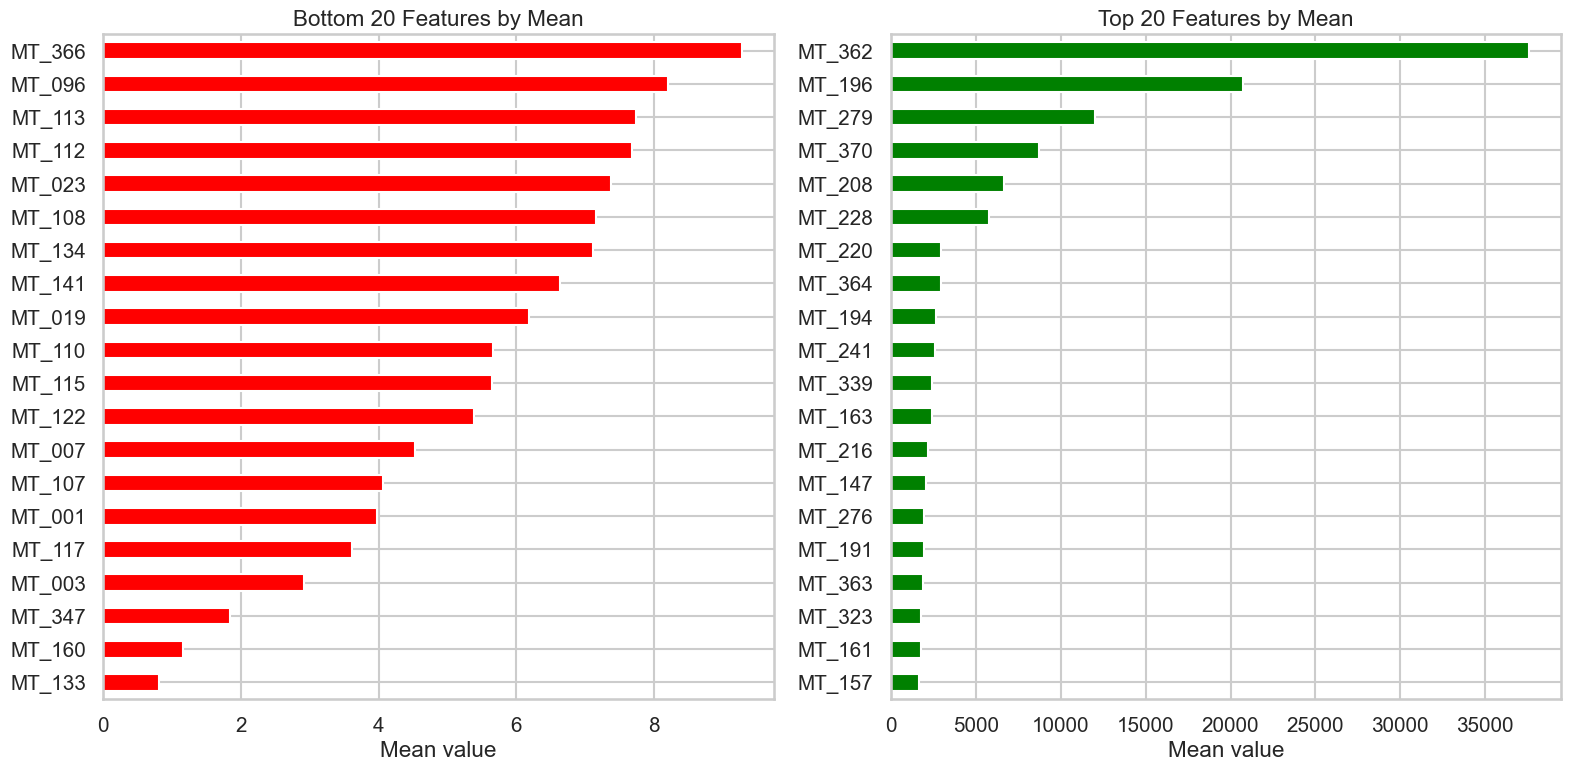

In [10]:
# Ensure correct ordering
means_sorted = means.sort_values(ascending=True)

top_n = 20
bottom_features = means_sorted.head(top_n)   # smallest means
top_features = means_sorted.tail(top_n)      # largest means

top_features = top_features.sort_values()
bottom_features = bottom_features.sort_values()

# Sort means explicitly
means_sorted = means.sort_values(ascending=True)

top_n = 20
bottom_features = means_sorted.head(top_n)
top_features = means_sorted.tail(top_n)

# Sort for nicer barh ordering
bottom_features = bottom_features.sort_values()
top_features = top_features.sort_values()

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

# Bottom 20
bottom_features.plot(kind='barh', ax=axes[0], color='red')
axes[0].set_title(f"Bottom {top_n} Features by Mean")
axes[0].set_xlabel("Mean value")

# Top 20
top_features.plot(kind='barh', ax=axes[1], color='green')
axes[1].set_title(f"Top {top_n} Features by Mean")
axes[1].set_xlabel("Mean value")

plt.tight_layout()
plt.show()

Analysis:

1. **Asymmetry in Means**:

   * The **top 20 features** (green, right panel) have extremely high mean values, with the highest around **35,000–40,000**.
   * The **bottom 20 features** (red, left panel) are much smaller, mostly below **10**.
   * This suggests a **highly skewed distribution**, likely a few customers/meters dominate the overall consum extremes.

3. **Insights**:

   * The top features might represent heavy or high-usage meters, possibly outliers or industrial customers.
   * Bottom features could indicate low usage or less active meters, possibly residential.


### Distribution of Electricity Usage

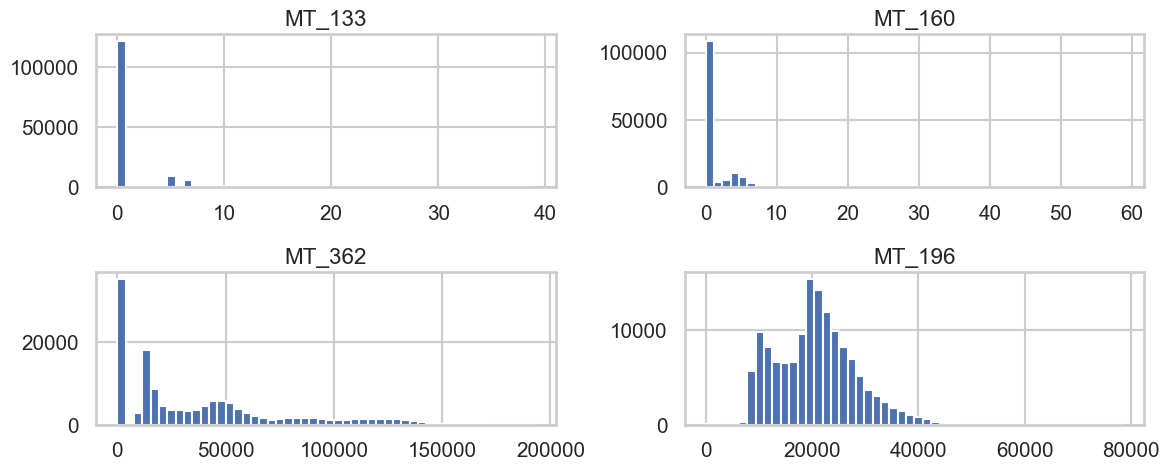

In [11]:
# Distribution of bottom 2 metres with top 2 metres
df[['MT_133','MT_160','MT_362','MT_196']].hist(bins=50);
plt.tight_layout()

The distributional analysis reveals two distinct consumption regimes.

MT_133 and MT_160 show highly concentrated low-usage patterns, while MT_362 and MT_196 exhibit heavy-tailed, high-variance behavior.

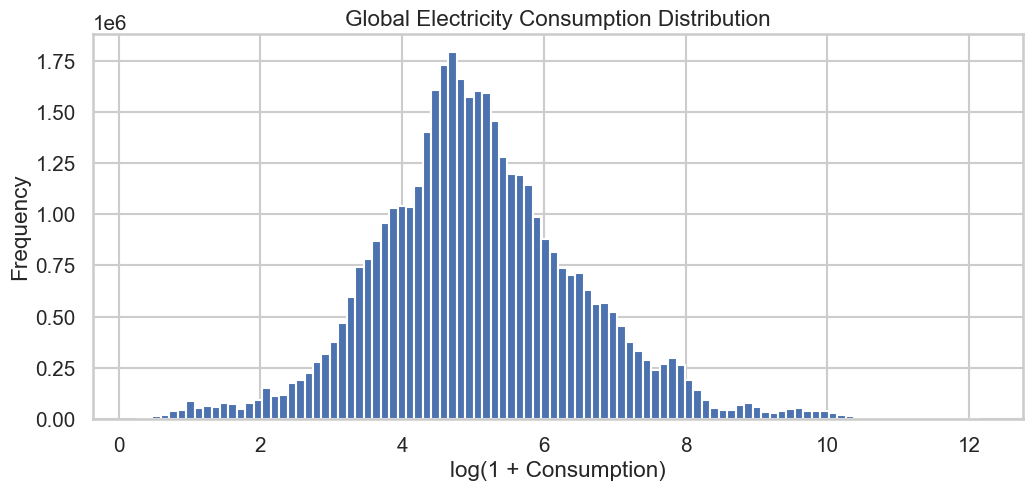

In [12]:
# Checking the distribution of the whole dataset
values = df.values.flatten()
values = values[values > 0]   # remove zeros if needed

plt.hist(np.log1p(values), bins=100)
plt.xlabel("log(1 + Consumption)") # log 0 is undefined 
plt.ylabel("Frequency")
plt.title("Global Electricity Consumption Distribution")
plt.show()

**Model Selection Justification**

We are justified in using a single global model because:

- The population does not exhibit clear multimodality after log transformation.
- Differences between low-, medium-, and high-consumption users form a continuous spectrum rather than discrete groups.
- Applying clustering would introduce artificial segmentation not supported by the underlying data distribution.

As shown in the global distribution analysis:

> *Log transformation removes scale-induced multimodality, supporting global modeling while allowing meter-levl effects.*
subgroups.*


### Time Patterns

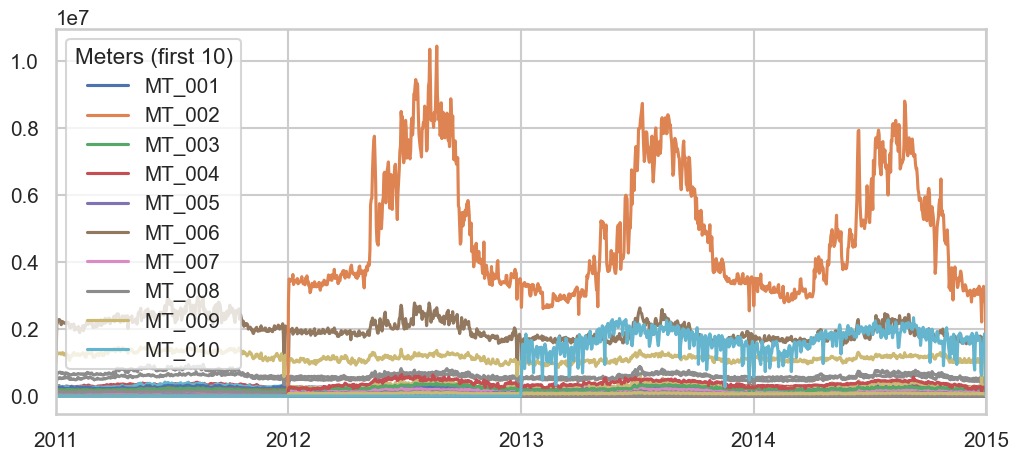

In [13]:
# Total electricity consumption per day across time
ax = df.resample('D').sum().plot()
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles[:10], labels[:10], title="Meters (first 10)");

**Key Patterns Observed:**

The time-series plot highlights substantial heterogeneity in electricity consumption levels and seasonal amplitude across meters(likely summer/winter). While absolute magnitudes differ, all series exhibit consistent temporal structure characterized by annual seasonality and recurring demand cycles. These differences primarily reflect scale rather than fundamentally distinct consumption regimes.

**Decision implication:**

This motivates normalization or transformation rather than segmentation.

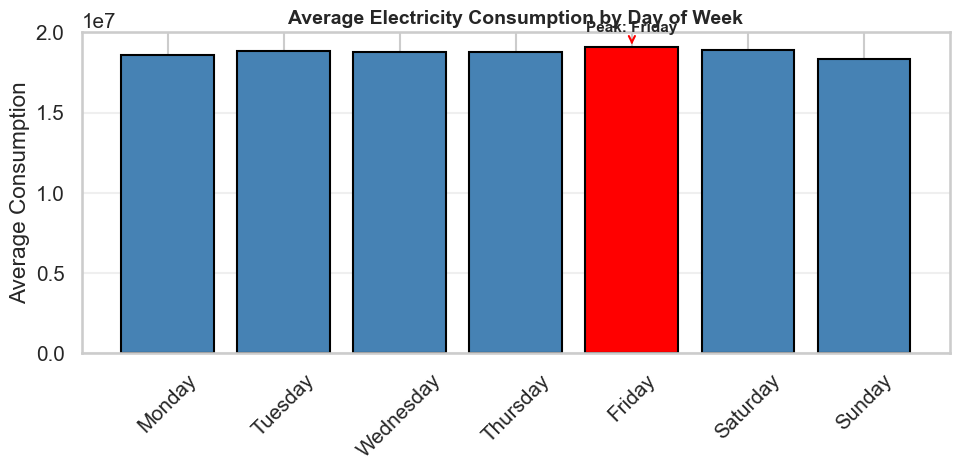

In [14]:
# Daily totals
daily_data = df.resample('D').sum().sum(axis=1)

# Day-of-week aggregation
day_of_week = daily_data.groupby(daily_data.index.dayofweek).mean()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 5))
colors = ['red' if i == day_of_week.idxmax() else 'steelblue' for i in day_of_week.index]

plt.bar(days, day_of_week.values, color=colors, edgecolor='black')
plt.title('Average Electricity Consumption by Day of Week', fontsize=14, fontweight='bold')
plt.ylabel('Average Consumption')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Peak label
peak_day = days[day_of_week.idxmax()]
plt.annotate(
    f'Peak: {peak_day}',
    xy=(day_of_week.idxmax(), day_of_week.max()),
    xytext=(day_of_week.idxmax(), day_of_week.max()*1.05),
    arrowprops=dict(arrowstyle='->', color='red'),
    ha='center',
    fontsize=11,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

**Deduction on daily pattern**

Average load is fairly flat Monday–Thursday, with a noticeable maximum on Friday, suggesting increased end‑of‑week activity or commercial usage. 

Weekend days show slightly lower averages, consistent with reduced industrial or office demand.

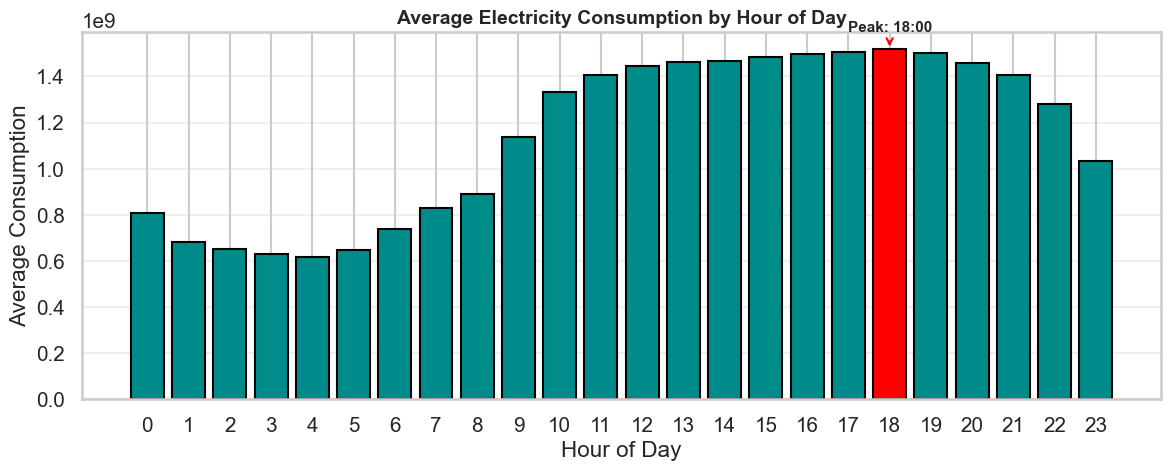

In [15]:
# Hourly aggregation (only if datetime index has hours)
hourly_data = df.groupby(df.index.hour).sum().sum(axis=1)

plt.figure(figsize=(12, 5))
colors = ['red' if i == hourly_data.idxmax() else 'darkcyan' for i in hourly_data.index]

plt.bar(hourly_data.index, hourly_data.values, color=colors, edgecolor='black')
plt.title('Average Electricity Consumption by Hour of Day', fontsize=14, fontweight='bold')
plt.xlabel('Hour of Day')
plt.ylabel('Average Consumption')
plt.xticks(range(0, 24))
plt.grid(axis='y', alpha=0.3)

peak_hour = hourly_data.idxmax()
plt.annotate(
    f'Peak: {peak_hour:02d}:00',
    xy=(peak_hour, hourly_data.max()),
    xytext=(peak_hour, hourly_data.max() * 1.05),
    arrowprops=dict(arrowstyle='->', color='red'),
    ha='center',
    fontsize=11,
    fontweight='bold'
)

plt.tight_layout()
plt.show()

**Deduction on hourly pattern**

Demand is lowest around 02:00–05:00, rises sharply after morning hours, and peaks between roughly 16:00 and 19:00 before slightly declining at night. 

This intraday profile is typical of residential and commercial usage, with higher activity and appliance use in late afternoon and early evenings.

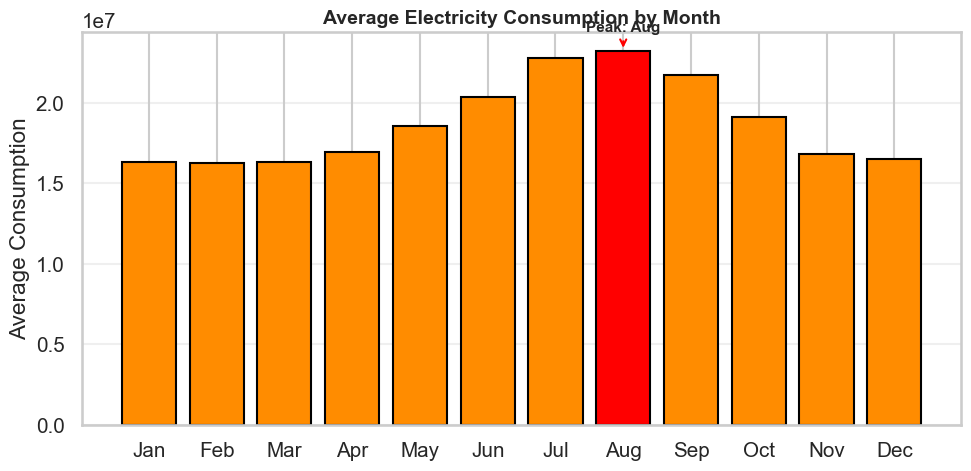

In [16]:
# Monthly aggregation
monthly_data = daily_data.groupby(daily_data.index.month).mean()
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

plt.figure(figsize=(10, 5))
colors = ['red' if i == monthly_data.idxmax() else 'darkorange' for i in monthly_data.index]

plt.bar(months, monthly_data.values, color=colors, edgecolor='black')
plt.title('Average Electricity Consumption by Month', fontsize=14, fontweight='bold')
plt.ylabel('Average Consumption')
plt.grid(axis='y', alpha=0.3)

peak_month = months[monthly_data.idxmax() - 1]
plt.annotate(
    f'Peak: {peak_month}',
    xy=(monthly_data.idxmax() - 1, monthly_data.max()),
    xytext=(monthly_data.idxmax() - 1, monthly_data.max() * 1.05),
    arrowprops=dict(arrowstyle='->', color='red'),
    ha='center',
    fontsize=11,
    fontweight='bold'
)

plt.tight_layout()
plt.show()


**Deduction on monthly pattern**
nDemand gradually rises from winter and spring, reaching a clear maximum in August, then declines toward December. 


This seasonal shape suggests strong summer effects, likely driven by cooling needs or tourism‑related consumption in Portugal.

**Possible outstanding insights**

Combination of Friday, August, and evening‑peak suggests planning for summer Friday evenings as the system’s most stressed periods.

### Correlation Between Meters

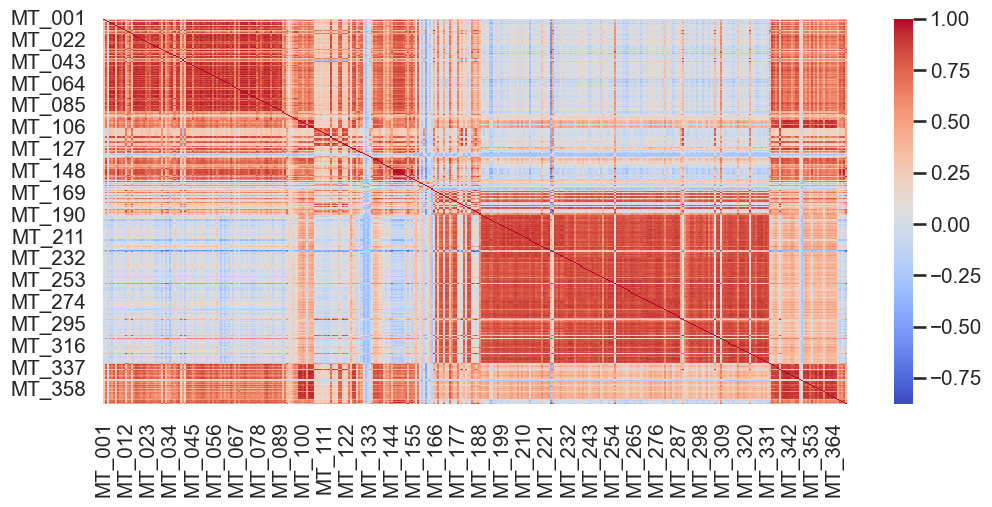

In [17]:
sns.heatmap(df.corr(), cmap="coolwarm");

The heatmap reveals distinct clusters of meters with high internal correlation, indicating groups of meters with similar usage patterns. Some meters show weak or negative correlation with others, suggesting unique or anomalous behavior. These insights can guide feature reduction, clustering, or further investigation of unusual patterns.

#### Are there distinct groups of meters with similar consumption behavior?

### Clustering / Pattern Discovery

In [18]:
# Ensure no missing values (KMeans cannot handle NaNs)
assert df.isnull().sum().sum() == 0, "Dataset contains missing values"

# Shape check
print("Original shape (time x meters):", df.shape)
print("Transposed shape (meters x time):", df.T.shape)

Original shape (time x meters): (140256, 370)
Transposed shape (meters x time): (370, 140256)


In [19]:
# Scaling to check on patterns
scaler = StandardScaler()
X = df.T  

X_scaled = scaler.fit_transform(X)

In [20]:
# Dimensionality reduction (mandatory for stability)
# PCA removes noise and redundancy

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

print("Explained variance:", pca.explained_variance_ratio_.sum())

Explained variance: 0.9981490888188532


**Deduction:**
Metres behave very similarly overall

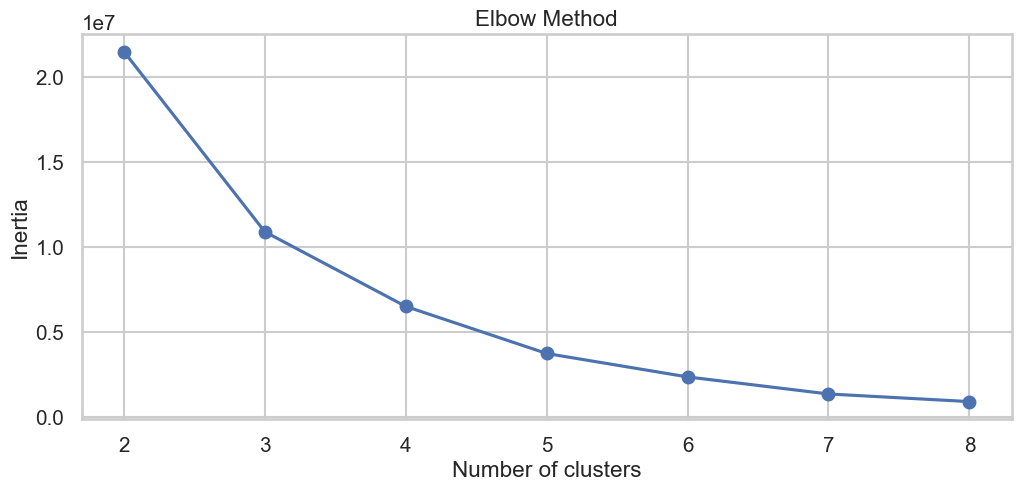

In [21]:
# Find the optimal number of clusters (Elbow Method)
inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10) # Run K-Means 10 times, each time with different initial centroids, and keep the solution with the lowest inertia (best clustering)
    km.fit(X_pca)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [22]:
# Fitting KMeans model
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_pca)

pd.Series(labels).value_counts()

0    367
2      2
1      1
Name: count, dtype: int64

In [23]:
summary = pd.DataFrame({
    "mean_usage": df.T.groupby(labels).mean().mean(axis=1),
    "std_usage": df.T.groupby(labels).std().mean(axis=1),
    "max_usage": df.T.groupby(labels).max().mean(axis=1)
})

summary

,mean_usage,std_usage,max_usage
0,341.051316,927.055209,12296.179330
1,37607.987537,NaN,37607.987537
2,16391.561053,6174.509108,20757.598314


`Cluster 0` — Normal / Typical Households

Lowest mean usage

Low-to-moderate variability

Contains the vast majority of meters

This cluster represents typical residential electricity consumption with stable usage patterns.

`Cluster 1` 

Extremely high mean and max usage

Only one meter

Variance undefined → singleton cluster

This meter exhibits consumption behavior far outside the norm, potentially indicating industrial use, faulty metering, or data issues.

`Cluster 2` — High-Usage / Volatile Consumers

Mean usage ~50× higher than Cluster 0

Very high variability

Small number of meters

These meters show consistently high and volatile consumption, likely representing heavy users or atypical households.

> Due to the high temporal resolution of the dataset, cluster behavior was analyzed using aggregated statistics. 

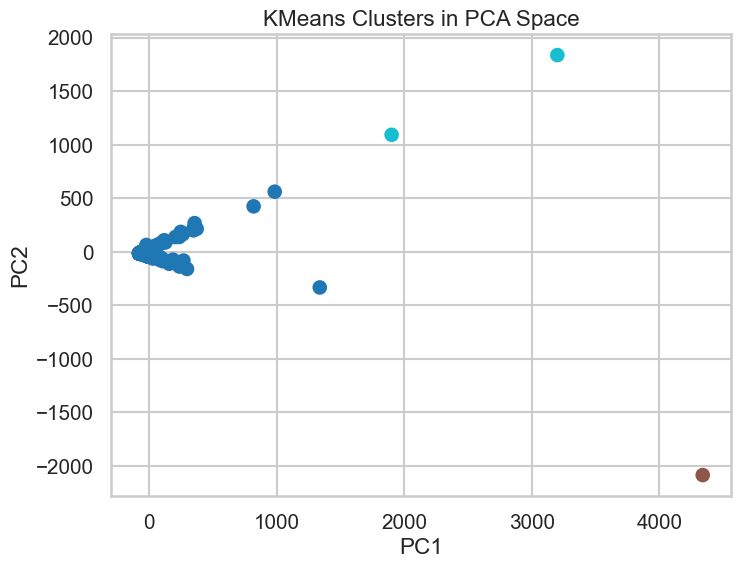

In [24]:
# Visualize clusters in PCA space

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, cmap='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters in PCA Space")
plt.show()

After log transformation and PCA, the electricity consumption profiles form a single dense manifold with no evidence of intrinsic multimodality. Apparent KMeans clusters are driven by a small number of extreme outliers rather than distinct customer segments, indicating that clustering would be artificial rather than data-driven.

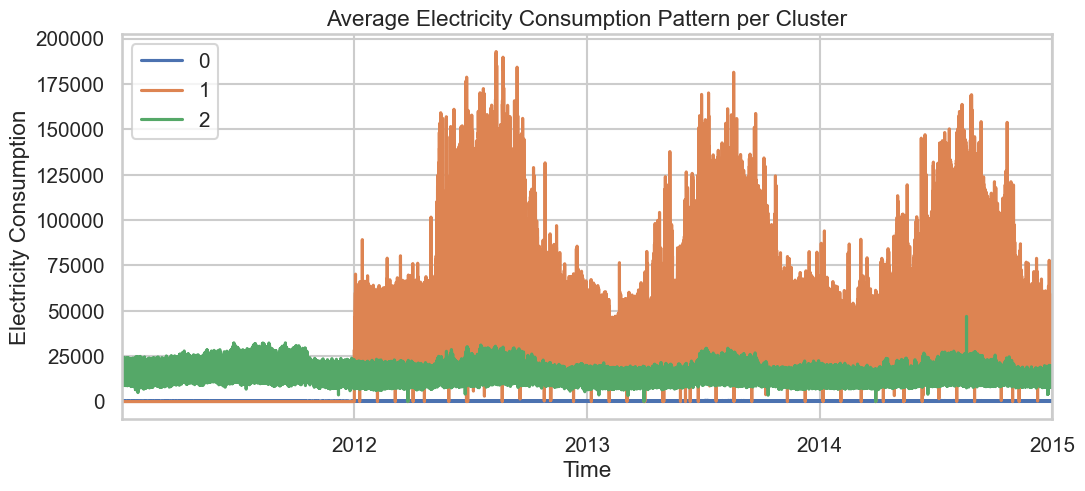

In [25]:
# Average load profile per cluster

cluster_profiles = df.T.groupby(labels).mean()

# Visualize cluster behavior
cluster_profiles.T.plot(
    title="Average Electricity Consumption Pattern per Cluster",
    figsize=(12, 5)
)

plt.xlabel("Time")
plt.ylabel("Electricity Consumption")
plt.show()

Most households behave very similarly in shape of consumption over time.

Only 3 meters behave very differently enough to be separated.

This is actually common in electricity datasets.

PCA showed that nearly all variance in electricity consumption is shared across meters, indicating highly homogeneous usage patterns. Clustering therefore revealed a dominant normal behavior and a small set of anomalous meters, which we reframe as an anomaly detection problem rather than forced segmentation.

There are no meaningful behavioral segments, only normal users + anomalies.

## DATA PREPARATION

### Data Cleaning and Transformation

#### Creating timestamp column

Since the dataset consists of fixed-interval measurements without an explicit timestamp column, timestamps are reconstructed using the known sampling frequency to enable proper time-series analysis.

In [26]:
# Rename the index
df.index.name = 'timestamp'

# Quick Check
print(df.shape)
df.head()

(140256, 370)


,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.770335,0.0,0.0,0.0,0.0,0.0,0.0,260.416667,45.721750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.203369,0.0,38.342246,20.363985,0.0,1935.185185,158.006363,1965.437788,0.0,0.0,838.461538,0.0,50.756208,24.570605,0.0,137.885196,80.797011,0.0,74.562212,76.792763,41.482587,0.0,0.0,0.0,93.291732,0.0,39.588859,45.717456,0.0,0.0,0.0,13.422819,22.123746,205.835962,327.859238,920.863309,285.607755,266.521027,1826.271186,218.274112,12166.666667,76.612903,148.867314,272.9

In [27]:
df = df.reset_index()  # timestamp becomes a regular column
df.head()

,timestamp,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 00:15:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.770335,0.0,0.0,0.0,0.0,0.0,0.0,260.416667,45.721750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.203369,0.0,38.342246,20.363985,0.0,1935.185185,158.006363,1965.437788,0.0,0.0,838.461538,0.0,50.756208,24.570605,0.0,137.885196,80.797011,0.0,74.562212,76.792763,41.482587,0.0,0.0,0.0,93.291732,0.0,39.588859,45.717456,0.0,0.0,0.0,13.422819,22.123746,205.835962,327.859238,920.863309,285.607755,266.521027,1826.271186,218.274112,12166.666667,76.612903,148.867314,272.935780,428.414097,173.089071,235.492958,319.354839,447.761194,288.135593,110.538373,345.578231,4235.294118,260.93750,472.868217,84.0,232.558140,603.036876,199.592668,207.532051,1328.903654,113.074205,680.529301,204.301075,1278.481013,81.728267,444.000000,517.333333,0.0,189.121951,325.833980,228.249744,3263.157895,582.689335,62.219731,380.410959,58.148148,84.924782,38

### Localize the timestamps

In [28]:
# Our timestamps do not yet have a timezone,but time depends on location. 
# Portugal changes clocks because of Daylight Saving Time (DST), so some hours:
#     1. Never exist (spring forward)
#     2. Happen twice (fall back)
# The below code makes the timestamps officially Portugal time and safely handles those DST issues.

In [29]:
# Convert to datetime 
df['timestamp'] = pd.to_datetime(df['timestamp'])

#  Localize to Portugal time
# Handle DST issues: 'nonexistent' = missing spring-forward hour, 'ambiguous' = repeated fall-back hour
df = df.set_index('timestamp')
df.index = df.index.tz_localize('Europe/Lisbon', nonexistent='NaT', ambiguous='NaT')

### Interpolate Missing hours

In [30]:
# Checking for missing values in the index
df.index.isna().sum()

32

In [31]:
# Drop rows with missing timestamps
df = df[df.index.notna()]

In [32]:
# Interpolate
df.interpolate(method='time', inplace=True)  # fills missing timestamps (NaT) linearly

### Handle duplicated hours (October DST)

In [33]:
# Find duplicated indices (NaT already handled, so duplicates have same timestamp)
# DST - Daylight Saving Time
duplicates = df.index.duplicated(keep=False)
if duplicates.any():
    # Split the aggregated values evenly between the two timestamps
    duplicated_rows = df[duplicates]
    df.loc[duplicates] = duplicated_rows / 2

### Conversion to Kenya time

In [34]:
df.index = df.index.tz_convert('Africa/Nairobi')

In [35]:
df.head()

,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-01 03:15:00+03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.770335,0.0,0.0,0.0,0.0,0.0,0.0,260.416667,45.721750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.203369,0.0,38.342246,20.363985,0.0,1935.185185,158.006363,1965.437788,0.0,0.0,838.461538,0.0,50.756208,24.570605,0.0,137.885196,80.797011,0.0,74.562212,76.792763,41.482587,0.0,0.0,0.0,93.291732,0.0,39.588859,45.717456,0.0,0.0,0.0,13.422819,22.123746,205.835962,327.859238,920.863309,285.607755,266.521027,1826.271186,218.274112,12166.666667,76.612903,148.867314

In [36]:
df = df.reset_index()  # timestamp becomes a regular column once more
df.head()

,timestamp,MT_001,MT_002,MT_003,MT_004,MT_005,MT_006,MT_007,MT_008,MT_009,MT_010,MT_011,MT_012,MT_013,MT_014,MT_015,MT_016,MT_017,MT_018,MT_019,MT_020,MT_021,MT_022,MT_023,MT_024,MT_025,MT_026,MT_027,MT_028,MT_029,MT_030,MT_031,MT_032,MT_033,MT_034,MT_035,MT_036,MT_037,MT_038,MT_039,MT_040,MT_041,MT_042,MT_043,MT_044,MT_045,MT_046,MT_047,MT_048,MT_049,MT_050,MT_051,MT_052,MT_053,MT_054,MT_055,MT_056,MT_057,MT_058,MT_059,MT_060,MT_061,MT_062,MT_063,MT_064,MT_065,MT_066,MT_067,MT_068,MT_069,MT_070,MT_071,MT_072,MT_073,MT_074,MT_075,MT_076,MT_077,MT_078,MT_079,MT_080,MT_081,MT_082,MT_083,MT_084,MT_085,MT_086,MT_087,MT_088,MT_089,MT_090,MT_091,MT_092,MT_093,MT_094,MT_095,MT_096,MT_097,MT_098,MT_099,MT_100,MT_101,MT_102,MT_103,MT_104,MT_105,MT_106,MT_107,MT_108,MT_109,MT_110,MT_111,MT_112,MT_113,MT_114,MT_115,MT_116,MT_117,MT_118,MT_119,MT_120,MT_121,MT_122,MT_123,MT_124,MT_125,MT_126,MT_127,MT_128,MT_129,MT_130,MT_131,MT_132,MT_133,MT_134,MT_135,MT_136,MT_137,MT_138,MT_139,MT_140,MT_141,MT_142,MT_143,MT_144,MT_145,MT_146,MT_147,MT_148,MT_149,MT_150,MT_151,MT_152,MT_153,MT_154,MT_155,MT_156,MT_157,MT_158,MT_159,MT_160,MT_161,MT_162,MT_163,MT_164,MT_165,MT_166,MT_167,MT_168,MT_169,MT_170,MT_171,MT_172,MT_173,MT_174,MT_175,MT_176,MT_177,MT_178,MT_179,MT_180,MT_181,MT_182,MT_183,MT_184,MT_185,MT_186,MT_187,MT_188,MT_189,MT_190,MT_191,MT_192,MT_193,MT_194,MT_195,MT_196,MT_197,MT_198,MT_199,MT_200,MT_201,MT_202,MT_203,MT_204,MT_205,MT_206,MT_207,MT_208,MT_209,MT_210,MT_211,MT_212,MT_213,MT_214,MT_215,MT_216,MT_217,MT_218,MT_219,MT_220,MT_221,MT_222,MT_223,MT_224,MT_225,MT_226,MT_227,MT_228,MT_229,MT_230,MT_231,MT_232,MT_233,MT_234,MT_235,MT_236,MT_237,MT_238,MT_239,MT_240,MT_241,MT_242,MT_243,MT_244,MT_245,MT_246,MT_247,MT_248,MT_249,MT_250,MT_251,MT_252,MT_253,MT_254,MT_255,MT_256,MT_257,MT_258,MT_259,MT_260,MT_261,MT_262,MT_263,MT_264,MT_265,MT_266,MT_267,MT_268,MT_269,MT_270,MT_271,MT_272,MT_273,MT_274,MT_275,MT_276,MT_277,MT_278,MT_279,MT_280,MT_281,MT_282,MT_283,MT_284,MT_285,MT_286,MT_287,MT_288,MT_289,MT_290,MT_291,MT_292,MT_293,MT_294,MT_295,MT_296,MT_297,MT_298,MT_299,MT_300,MT_301,MT_302,MT_303,MT_304,MT_305,MT_306,MT_307,MT_308,MT_309,MT_310,MT_311,MT_312,MT_313,MT_314,MT_315,MT_316,MT_317,MT_318,MT_319,MT_320,MT_321,MT_322,MT_323,MT_324,MT_325,MT_326,MT_327,MT_328,MT_329,MT_330,MT_331,MT_332,MT_333,MT_334,MT_335,MT_336,MT_337,MT_338,MT_339,MT_340,MT_341,MT_342,MT_343,MT_344,MT_345,MT_346,MT_347,MT_348,MT_349,MT_350,MT_351,MT_352,MT_353,MT_354,MT_355,MT_356,MT_357,MT_358,MT_359,MT_360,MT_361,MT_362,MT_363,MT_364,MT_365,MT_366,MT_367,MT_368,MT_369,MT_370
0,2011-01-01 03:15:00+03:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,71.770335,0.0,0.0,0.0,0.0,0.0,0.0,260.416667,45.721750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.203369,0.0,38.342246,20.363985,0.0,1935.185185,158.006363,1965.437788,0.0,0.0,838.461538,0.0,50.756208,24.570605,0.0,137.885196,80.797011,0.0,74.562212,76.792763,41.482587,0.0,0.0,0.0,93.291732,0.0,39.588859,45.717456,0.0,0.0,0.0,13.422819,22.123746,205.835962,327.859238,920.863309,285.607755,266.521027,1826.271186,218.274112,12166.666667,76.612903,148.867314,272.935780,428.414097,173.089071,235.492958,319.354839,447.761194,288.135593,110.538373,345.578231,4235.294118,260.93750,472.868217,84.0,232.558140,603.036876,199.592668,207.532051,1328.903654,113.074205,680.529301,204.301075,1278.481013,81.728267,444.000000,517.333333,0.0,189.121951,325.833980,228.249744,3263.157895,582.689335,62.219731,380.410959,58.148148,84.924

#### Conversion from Wide to Long format (Melting)

In [37]:
meter_columns = [c for c in df.columns if c != "timestamp"] # excluding timestamp format

df_long = df.melt(
    id_vars="timestamp",
    value_vars=meter_columns, # columns that get stacked
    var_name="meter_id",
    value_name="consumption_kwh"
)

print(df_long.shape)
df_long.head()

(51882880, 3)


,timestamp,meter_id,consumption_kwh
0,2011-01-01 03:15:00+03:00,MT_001,0.0
1,2011-01-01 03:30:00+03:00,MT_001,0.0
2,2011-01-01 03:45:00+03:00,MT_001,0.0
3,2011-01-01 04:00:00+03:00,MT_001,0.0
4,2011-01-01 04:15:00+03:00,MT_001,0.0


#### Count negative values

In [38]:
num_negative = (df_long["consumption_kwh"] < 0).sum()
print(f"Number of negative values: {num_negative}")

Number of negative values: 0


#### Remove dead meters (all-zero meters)

In [39]:
meter_totals = df_long.groupby("meter_id")["consumption_kwh"].sum()
active_meters = meter_totals[meter_totals > 0].index

df_long = df_long[df_long["meter_id"].isin(active_meters)]

print(f"Active meters: {df_long['meter_id'].nunique()}")

Active meters: 370


#### Sanity Check

In [40]:
print(df_long["timestamp"].min(), df_long["timestamp"].max())
print(df_long.groupby("meter_id").size().describe())

2011-01-01 03:15:00+03:00 2015-01-01 03:00:00+03:00
count       370.0
mean     140224.0
std           0.0
min      140224.0
25%      140224.0
50%      140224.0
75%      140224.0
max      140224.0
dtype: float64


`Interpretation`

Data spans exactly 4 years, starting at 2011-01-01 00:15:00 and ending at 2015-01-01 00:00:00.
Every meter has exactly 140,256 rows.

std = 0 confirms there is no variation, i.e., all meters have complete data.

We don’t have missing timestamps for any meter.

We also don’t have “dead” meters—each meter recorded data for the entire period.

This is why our earlier check returned 370 active meters; all are active.

#### Create daily aggregates

In [41]:
df_long["date"] = df_long["timestamp"].dt.date
df_long["day_of_week"] = df_long["timestamp"].dt.dayofweek
df_long["is_weekend"] = df_long["day_of_week"].isin([5, 6]).astype(int)

daily_df = (
    df_long
    .groupby(["meter_id", "date"])
    .agg(
        daily_total=("consumption_kwh", "sum"),
        daily_mean=("consumption_kwh", "mean"),
        daily_std=("consumption_kwh", "std"),
        daily_min=("consumption_kwh", "min"),
        daily_max=("consumption_kwh", "max"),
        is_weekend=("is_weekend", "first"),
        day_of_week=("day_of_week", "first")
    )
    .reset_index()
)

daily_df["daily_std"] = daily_df["daily_std"].fillna(0)

print(daily_df.shape)
daily_df.head()

(540940, 9)


,meter_id,date,daily_total,daily_mean,daily_std,daily_min,daily_max,is_weekend,day_of_week
0,MT_001,2011-01-01,0.0,0.0,0.0,0.0,0.0,1,5
1,MT_001,2011-01-02,0.0,0.0,0.0,0.0,0.0,1,6
2,MT_001,2011-01-03,0.0,0.0,0.0,0.0,0.0,0,0
3,MT_001,2011-01-04,0.0,0.0,0.0,0.0,0.0,0,1
4,MT_001,2011-01-05,0.0,0.0,0.0,0.0,0.0,0,2


We have 540,940 rows and 9 columns.

Since we have 370 meters, this means on average:

540
,
940
/
370
≈
1
,
462
 days per meter

That makes sense because your data spans 4 years (~1,461 days including leap year adjustments).

In [42]:
# Testing the above conclusion
mt001 = daily_df[daily_df["meter_id"] == "MT_001"]
print(f"Rows for MT_001: {len(mt001)}")

Rows for MT_001: 1462


#### Save Processed Data

In [43]:
os.makedirs("data/processed", exist_ok=True)

daily_df.to_csv("data/processed/daily_consumption.csv", index=False)
print("Saved daily_consumption.csv")

Saved daily_consumption.csv


### Synthetic Theft Injection

In [44]:
# Select random customers for theft based on IEEE-defined patterns
theft_percentage = 0.05  # 5% of all customers
customers = daily_df['meter_id'].unique()
n_theft_customers = int(len(customers) * theft_percentage)

# Randomly pick customers
theft_customers = np.random.choice(customers, size=n_theft_customers, replace=False)
print(f"Selected {len(theft_customers)} customers for theft injection")

Selected 18 customers for theft injection


In [45]:
# Print the list of selected customers
print("Selected customers for theft injection:")
print(theft_customers)

Selected customers for theft injection:
['MT_233' 'MT_166' 'MT_225' 'MT_174' 'MT_222' 'MT_370' 'MT_130' 'MT_265'
 'MT_038' 'MT_262' 'MT_177' 'MT_164' 'MT_064' 'MT_244' 'MT_090' 'MT_168'
 'MT_283' 'MT_107']


The cell below injects realistic customer-level electricity theft by modifying historical consumption according to distinct real-world fraud behaviors, thereby enabling supervised learning under controlled and interpretable conditions.

In [46]:
# Initialize theft column
daily_df['is_theft'] = 0

# To keep track of what pattern we applied to each customer
theft_patterns = {}

# Loop through customers and inject theft
for customer in theft_customers:
    
    # Randomly pick a theft pattern based on IEEE research probabilities
    pattern_type = np.random.choice(
        ['meter_tampering', 'cable_bypass', 'partial_bypass', 'time_based', 'gradual'],
        p=[0.35, 0.25, 0.20, 0.15, 0.05]
    )
        # So for each customer:
            # There is a 35% chance they get meter tampering
            # A 25% chance of cable bypass
            # A 20% chance of partial bypass
            # A 15% chance of time-based theft
            # A 5% chance of gradual theft
    
    # Get customer's data
    mask = daily_df['meter_id'] == customer
    customer_data = daily_df[mask].copy()

    # Applying the chosen theft patterns
    # Pattern 1: Meter Tampering - Manipulates electricity meter so that it records only a fraction of the actual consumption.
    if pattern_type == 'meter_tampering':
        reduction_factor = np.random.uniform(0.4, 0.8)  # reduce 40-80%
        theft_days = np.random.random(len(customer_data)) < 0.7  # affect about 70% of days
        noise = np.random.normal(0, 0.05, sum(theft_days))  # small random noise
        customer_data.loc[theft_days, 'daily_total'] *= (1 - reduction_factor) # Update daily total
        customer_data.loc[theft_days, 'daily_total'] *= (1 + noise) # Add some noise
    
    # Pattern 2: Cable Bypass - Connects appliances directly to the power line, completely bypassing the meter.
    elif pattern_type == 'cable_bypass':
        n_periods = np.random.randint(2, 5)
        period_lengths = np.random.randint(5, 15, n_periods) 
        start_idx = 0
        for period_len in period_lengths:
            if start_idx + period_len < len(customer_data):
                customer_data.iloc[start_idx:start_idx+period_len, 
                                   customer_data.columns.get_loc('daily_total')] = 0
                start_idx += period_len + np.random.randint(10, 30)
    
    # Pattern 3: Partial Bypass - Only part of the household load bypasses the meter
    elif pattern_type == 'partial_bypass':
        threshold = np.percentile(customer_data['daily_total'], 30)
        high_days = customer_data['daily_total'] > threshold
        variation = np.random.uniform(-0.1, 0.1, sum(high_days))
        customer_data.loc[high_days, 'daily_total'] = threshold * (1 + variation)
    
    # Pattern 4: Time-Based Theft - Theft occurs only during specific time periods when inspection is unlikely e.g holidays
    elif pattern_type == 'time_based':
        if np.random.random() < 0.5:
            theft_days = customer_data['day_of_week'].isin([5, 6])  # weekends
        else:
            theft_days = customer_data['day_of_week'].isin([0, 1, 2, 3, 4])  # weekdays
        customer_data.loc[theft_days, 'daily_total'] *= 0.4  # 60% reduction
    
    # Pattern 5: Gradual Theft - Slowly increases of theft over time to test detection thresholds, avoid sudden anomalies
    elif pattern_type == 'gradual':
        n_days = len(customer_data)
        reduction_factors = np.linspace(0, 0.7, n_days)
        customer_data['daily_total'] *= (1 - reduction_factors)

    # Recompute derived daily statistics for consistency over a rolling window (e.g., last 7 or 30 days)
    customer_data['daily_mean'] = customer_data['daily_total'].rolling(30, min_periods=1).mean()
    customer_data['daily_std']  = customer_data['daily_total'].rolling(30, min_periods=1).std().fillna(0)
    customer_data['daily_min']  = customer_data['daily_total'].rolling(30, min_periods=1).min()
    customer_data['daily_max']  = customer_data['daily_total'].rolling(30, min_periods=1).max()
    
    # Write back modified data
    daily_df.loc[mask, 'daily_total'] = customer_data['daily_total']
    daily_df.loc[mask, 'daily_mean']  = customer_data['daily_mean']
    daily_df.loc[mask, 'daily_std']   = customer_data['daily_std']
    daily_df.loc[mask, 'daily_min']   = customer_data['daily_min']
    daily_df.loc[mask, 'daily_max']   = customer_data['daily_max']
    daily_df.loc[mask, 'is_theft']    = 1
    
    # Record pattern info
    theft_patterns[customer] = {
        'pattern': pattern_type,
        'start_date': customer_data['date'].min(),
        'end_date': customer_data['date'].max()
    }

# Summary
print(f"\nTheft injection complete: {daily_df['is_theft'].sum()} theft records")
print(f"\nClass distribution:\n{daily_df['is_theft'].value_counts()}")
customer_data.head()


Theft injection complete: 26316 theft records

Class distribution:
is_theft
0    514624
1     26316
Name: count, dtype: int64


,meter_id,date,daily_total,daily_mean,daily_std,daily_min,daily_max,is_weekend,day_of_week,is_theft
154972,MT_107,2011-01-01,0.0,0.0,0.0,0.0,0.0,1,5,0
154973,MT_107,2011-01-02,0.0,0.0,0.0,0.0,0.0,1,6,0
154974,MT_107,2011-01-03,0.0,0.0,0.0,0.0,0.0,0,0,0
154975,MT_107,2011-01-04,0.0,0.0,0.0,0.0,0.0,0,1,0
154976,MT_107,2011-01-05,0.0,0.0,0.0,0.0,0.0,0,2,0


In [47]:
print("Class distribution:")
print(daily_df['is_theft'].value_counts(normalize=True))

Class distribution:
is_theft
0    0.951351
1    0.048649
Name: proportion, dtype: float64


In [48]:
# Pick one customer from the theft list to test
theft_customer = theft_customers[0]  # first customer in the list

# Filter the main dataframe for that customer
customer_data = daily_df[daily_df['meter_id'] == theft_customer].sort_values('date')

# Inspect the first few rows
customer_data.head()

       meter_id        date   daily_total   daily_mean    daily_std  \
339184   MT_233  2011-01-01   3311.874108  3311.874108     0.000000   
339185   MT_233  2011-01-02   6231.100611  4771.487360  2064.204856   
339186   MT_233  2011-01-03   6127.042295  5223.339005  1656.194606   
339187   MT_233  2011-01-04  13363.317498  7258.333628  4288.760448   
339188   MT_233  2011-01-05  13774.908947  8561.648692  4721.043361   

          daily_min     daily_max  is_weekend  day_of_week  is_theft  
339184  3311.874108   3311.874108           1            5         1  
339185  3311.874108   6231.100611           1            6         1  
339186  3311.874108   6231.100611           0            0         1  
339187  3311.874108  13363.317498           0            1         1  
339188  3311.874108  13774.908947           0            2         1  


### Feature Engineering

#### Benford's Law

`Benford Law Analysis of Electricity Consumption`

Benford’s Law is about the distribution of the first digit in naturally occurring numerical data. It says that in many real-world datasets (financial data, populations, electricity usage, etc.), the smaller digits appear as the first digit more frequently than larger digits.

When you want to check if a dataset follows Benford’s Law, you compare the observed frequency of each first digit in your data to the expected frequency given by Benford.

`A common metric is the chi-square statistic`:

**Benford’s Law predicts first-digit distribution, and the chi-square deviation measures how far your data is from this prediction.**

**Objective:**  - Identify meters whose consumption patterns deviate strongly from expected natural distributions, which could indicate anomalies or possible theft.

In [49]:
# Safe divide helper
# Important when dealing with scaled or normalized features, where a zero denominator could break the pipeline

def safe_divide(numerator, denominator, eps=1e-5): # A tiny value added to the denominator to prevent division by zero, default is 1e-5
    return numerator / (denominator + eps)

# Benford Law violation

def calculate_benford_violation(series):
    
    """Compute chi-square deviation from Benford's Law for first digits."""
    
    positive = series[series > 0] # Ignoring negative values
    if len(positive) == 0: # If there are no positive numbers, return 0
        return 0
        
    # Convert each positive value to a string and extract the first character, then convert back to integer.
    first_digits = positive.astype(str).str[0].astype(int)
    
    # Compute the expected distribution of first digits according to Benford's Law
    expected = np.log10(1 + 1/np.arange(1, 10))
    
    # Gives higher probability to small digits (1 appears most frequently).
    observed = first_digits.value_counts(normalize=True).reindex(range(1, 10), fill_value=0)

    # Convert proportions to actual counts for the chi-square calculation.
    obs_actual = observed * len(positive)
    expected_actual = expected * len(positive)

    # Compute the chi-square statistic:
    chi2 = np.sum((obs_actual - expected_actual)**2 / (expected_actual + 1e-10))
    return chi2

In [50]:
# Rolling statistics - calculated over a moving window of past observations rather than over the entire dataset.

def rolling_features(group, window_sizes=[7, 30, 90]):
    
    """Compute rolling z-scores, percent change, and volatility without data leakage."""
    
    features = {} # An empty dictionary to store all rolling features
    for w in window_sizes:     # Loop through each window size (e.g., 7, 30, 90 days)
        if len(group) >= w:    # Only calculate if we have enough historical data
            
            # exclude last day for rolling calculation to avoid data leakage
            window_vals = group['daily_total'].iloc[-w:-1]
            window_mean = window_vals.mean()
            window_std = window_vals.std()

            # This is the most recent day’s consumption.
            current_val = group['daily_total'].iloc[-1]

            features[f'z_score_{w}d'] = safe_divide(current_val - window_mean, window_std) # Z-score: (current - mean) / std
                                                                # Shows how abnormal today is relative to recent history
            features[f'pct_change_{w}d'] = safe_divide(current_val - window_mean, window_mean) # Percent change: relative difference from recent average.
                                                                # Highlights large spikes or drops
            features[f'volatility_{w}d'] = safe_divide(window_std, window_mean) # Volatility: variability relative to the mean.
                                                                # High value → consumption is erratic; low → stable.
    return features

Electricity theft is often; Sudden (drop or spike), Relative to recent behavior, not lifetime behavior.

Rolling statistics let you detect:

“Today looks abnormal compared to my own last 30 days”

Not “today looks different from the average customer”

That makes them customer-specific anomaly detectors.

In [51]:
# Outliers & sudden changes
# It answers questions like:
    # 1. Does this customer have unusually high or low days?
    # 2. Do they suddenly drop or spike consumption?
    # 3. Are these changes rare compared to their own history?

def outlier_features(group):
    """Compute IQR outliers, max daily drop/spike, sudden drop/spike counts."""
    features = {}
    q1, q3 = group['daily_total'].quantile([0.25, 0.75])
    iqr = q3 - q1
    features['iqr_outlier_count'] = ((group['daily_total'] < (q1 - 1.5*iqr)) |
                                     (group['daily_total'] > (q3 + 1.5*iqr))).sum()

    pct_change = group['daily_total'].pct_change() # This captures day-to-day shocks, not absolute levels.
    features['max_daily_drop'] = pct_change.min() # biggest single-day fall in consumption
    features['max_daily_spike'] = pct_change.max() # biggest single-day jump
    features['sudden_drop_count'] = (pct_change < pct_change.quantile(0.05)).sum() # Finds the most extreme 5% of changes
    features['sudden_spike_count'] = (pct_change > pct_change.quantile(0.95)).sum() # Counts how often they happen
    return features

`What this detects;`

Days that are too low or too high compared to the customer’s own behavior

`Why this matters for theft:`

Bypassing or partial shunting → unusually low days

Tampering or reconnection → sudden high days

Repeated outliers = suspicious behavior

This gives a count

`Why percentiles (not fixed numbers)?` Because:

Industrial users ≠ residential users

Absolute thresholds don’t generalize

Percentiles capture relative abnormality

`Feature	Detects`

iqr_outlier_count -> Abnormal levels

max_daily_drop/spike -> One-off events

sudden_*_count -> Repeated suspicious behavior

Together, they distinguish: Random noise, Seasonal changes, Intentional manipulation

In [52]:
# Autocorrelation
# measures how similar a time series is to itself after a time shift (lag).
def autocorr_features(group):
    """Compute weekly and monthly autocorrelations."""
    
    autocorr7 = group['daily_total'].autocorr(lag=7)
    autocorr30 = group['daily_total'].autocorr(lag=30)
    return {
        'autocorr_weekly': 0 if pd.isna(autocorr7) else autocorr7,
        'autocorr_monthly': 0 if pd.isna(autocorr30) else autocorr30
    }

>“If I know today’s consumption, can I predict consumption 7 or 30 days ago?”

High autocorrelation → stable, habitual behavior

Low or negative autocorrelation → disrupted or manipulated behavior

In [53]:
# Entropy - measures unpredictability or disorder.
# How random does this customer’s electricity usage look?

def entropy_feature(group):
    """Compute consumption entropy."""
    hist, _ = np.histogram(group['daily_total'], bins='fd') # 'fd' (Freedman–Diaconis rule) -Automatically chooses bin width based on:
                                                                    # Data variability (IQR), Sample size
    probs = hist / hist.sum() if hist.sum() > 0 else np.zeros_like(hist) # Convert counts into probabilities
    return {'consumption_entropy': entropy(probs)}


Low entropy → predictable, regular behavior

High entropy → irregular, chaotic behavior

In [54]:
# Seasonality
def seasonality_feature(group):
    """Compute monthly seasonality strength."""
    if len(group) >= 365: # Only calculate seasonality if we have at least one year of daily data.
        monthly_avg = group.groupby(group['date'].dt.month)['daily_total'].mean()
        return {'seasonality_strength': safe_divide(monthly_avg.std(), group['daily_total'].std())}
    else:
        return {'seasonality_strength': 0} # If less than 365 days → feature = 0


Seasonality strength measures how strongly a customer’s electricity usage follows a regular monthly pattern. Disruptions, irregularities, or theft reduce this feature.

In [55]:
# Cumulative deviation - measures how the most recent daily consumption differs from the customer’s average so far.

def cumulative_deviation(group):
    """Deviation of last value from cumulative mean."""
    current_val = group['daily_total'].iloc[-1] # Focuses only on the last recorded daily consumption.
    cum_mean = group['daily_total'].expanding().mean()
    return {'cum_dev_last': current_val - cum_mean.iloc[-1]}

#### Feature Creation

**Main Feature Engineering Pipeline**

This function generates a comprehensive set of features for each electricity meter.

Features are grouped to capture different aspects of consumption behavior:

1. Basic Statistics      → overall usage, variability, peaks, troughs, weekday/weekend patterns
2. Rolling Statistics    → short- and medium-term context (7, 30, 90 days), including z-scores, pct changes, and volatility
3. Outliers & Sudden Changes → violations of typical patterns, extreme drops/spikes
4. Benford Law Violation → detects irregular first-digit distributions (potential fraud indicator)
5. Autocorrelation       → pattern consistency across weekly/monthly lags
6. Entropy               → randomness or disorder in consumption
7. Seasonality           → monthly seasonal patterns strength
8. Cumulative Deviation  → deviation of the last value from the historical mean

>All numeric features are scaled and clipped to avoid extreme values.

In [56]:
# Main feature creation

def create_features(df, min_history=30, rolling_windows=[7,30,90]):
    """Generate all features for each meter_id."""
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    df = df.dropna(subset=['date', 'daily_total']).copy()
    df['month'] = df['date'].dt.month

    features_list = []

    for meter_id, group in df.groupby('meter_id'):
        group = group.sort_values('date').reset_index(drop=True)
        if len(group) < min_history:
            continue

        feat = {'meter_id': meter_id}

        # Basic stats
        mean_total = group['daily_total'].mean()
        std_total = group['daily_total'].std()
        feat.update({
            'total_consumption': group['daily_total'].sum(),
            'avg_consumption': mean_total,
            'std_consumption': std_total,
            'cv_consumption': safe_divide(std_total, mean_total),
            'peak_to_avg_ratio': safe_divide(group['daily_total'].max(), mean_total),
            'trough_to_avg_ratio': safe_divide(group['daily_total'].min(), mean_total),
            'weekend_weekday_ratio': safe_divide(
                group[group['day_of_week']>=5]['daily_total'].mean(),
                group[group['day_of_week']<5]['daily_total'].mean()
            )
        })

        # Rolling stats
        feat.update(rolling_features(group, rolling_windows))

        # Outliers & sudden changes
        feat.update(outlier_features(group))

        # Benford violation
        feat['benford_violation'] = calculate_benford_violation(group['daily_total'])

        # Autocorrelation
        feat.update(autocorr_features(group))

        # Entropy
        feat.update(entropy_feature(group))

        # Seasonality
        feat.update(seasonality_feature(group))

        # Cumulative deviation
        feat.update(cumulative_deviation(group))

        # Theft flag
        if 'is_theft' in group.columns:
            feat['is_theft'] = group['is_theft'].max()

        features_list.append(feat)

    # Build DataFrame
    features_df = pd.DataFrame(features_list)

    # Scale numeric features
    numeric_cols = [c for c in features_df.columns
                    if c not in ['meter_id', 'is_theft'] and pd.api.types.is_numeric_dtype(features_df[c])]
    features_df[numeric_cols] = features_df[numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
    features_df[numeric_cols] = features_df[numeric_cols].clip(-1e6, 1e6)
    features_df[numeric_cols] = StandardScaler().fit_transform(features_df[numeric_cols])

    print(f"Feature engineering complete: {features_df.shape[0]} customers, {features_df.shape[1]} features")
    return features_df

In [57]:
# Load the data
df_with_theft = pd.read_csv('data/synthetic/consumption_with_theft.csv')

# Ensure 'day_of_week' exists if used in weekend_weekday_ratio
if 'day_of_week' not in df_with_theft.columns:
    df_with_theft['day_of_week'] = pd.to_datetime(df_with_theft['date']).dt.dayofweek

# Call feature creation
features_df = create_features(df_with_theft)

# Save to CSV
features_df.to_csv('data/processed/final_features.csv', index=False)

# Inspect the output
features_df.head()              

Feature engineering complete: 370 customers, 29 features


,meter_id,total_consumption,avg_consumption,std_consumption,cv_consumption,peak_to_avg_ratio,trough_to_avg_ratio,weekend_weekday_ratio,z_score_7d,pct_change_7d,volatility_7d,z_score_30d,pct_change_30d,volatility_30d,z_score_90d,pct_change_90d,volatility_90d,iqr_outlier_count,max_daily_drop,max_daily_spike,sudden_drop_count,sudden_spike_count,benford_violation,autocorr_weekly,autocorr_monthly,consumption_entropy,seasonality_strength,cum_dev_last,is_theft
0,MT_001,-8.235056,-0.353968,-0.219993,0.029563,-0.452893,-0.739103,-0.022601,-0.666920,-0.227602,-1.032727,0.087516,0.110081,-0.371006,0.182066,0.077870,-0.434249,-0.634957,-0.525067,-0.092986,-0.233550,-0.234548,-0.305877,0.646489,0.891279,-1.344232,-1.546750,0.057205,1
1,MT_002,0.169091,-0.337299,-0.204821,0.057069,-0.279015,-0.739103,0.174044,2.527353,0.056448,-1.223216,1.881218,0.255880,-0.747816,-0.010038,0.004714,-0.631315,-0.634957,-0.724252,-0.092986,-0.233550,-0.234548,0.036763,0.657997,0.880649,-0.751879,-0.911508,0.061381,0
2,MT_003,-5.642381,-0.352380,-0.210402,4.379356,10.180543,-0.739103,0.400856,0.146316,0.848484,1.765130,0.259043,0.313986,0.171438,0.244320,0.125120,-0.301502,-0.244917,-2.037416,-0.092986,-0.987705,-0.234548,-0.961802,-0.644819,-1.773756,-0.651294,0.494408,0.054777,0
3,MT_004,0.169091,-0.285409,-0.156821,0.072656,-0.221567,-0.739103,0.328893,-0.387550,-0.168304,-1.017927,0.342246,0.186939,-0.519956,0.912687,0.556514,-0.255794,1.883197,1.027246,-0.092986,-0.233550,-0.234548,-0.519548,0.713796,0.844148,0.257945,-0.716566,0.159527,0
4,MT_005,0.169091,-0.323382,-0.189973,0.148513,-0.192621,-0.739103,-0.114376,-0.387316,-0.160603,-1.105553,0.495636,0.247340,-0.498416,0.942942,0.921158,0.202544,-0.634957,0.770707,-0.092986,-0.233550,-0.234548,-0.695105,0.515393,0.527933,0.149902,-0.107182,0.114696,0


## Columns Explanation

#### **Customer identifier**

* **`meter_id`** → Unique ID for each electricity meter/customer.

---

#### **Basic consumption statistics**

* **`total_consumption`** → Sum of all daily consumption values for this meter.
* **`avg_consumption`** → Mean daily consumption.
* **`std_consumption`** → Standard deviation of daily consumption, measures variability.
* **`cv_consumption`** → Coefficient of variation = `std / mean`, shows relative variability.
* **`peak_to_avg_ratio`** → Maximum daily value divided by mean, indicates unusually high spikes.
* **`trough_to_avg_ratio`** → Minimum daily value divided by mean, shows unusually low dips.
* **`weekend_weekday_ratio`** → Average weekend consumption / average weekday consumption; captures consumption patterns across the week.

---

#### **Rolling statistics (context)**

* **`z_score_7d`, `z_score_30d`, `z_score_90d`** → Standardized deviation of the last day from the rolling mean over 7, 30, 90 days. Detects unusual recent behavior.
* **`pct_change_7d`, `pct_change_30d`, `pct_change_90d`** → Relative change of the last day compared to rolling mean.
* **`volatility_7d`, `volatility_30d`, `volatility_90d`** → Rolling standard deviation divided by rolling mean, shows variability over different time windows.

---

#### **Outliers / sudden changes (violations of pattern)**

* **`iqr_outlier_count`** → Number of days outside 1.5×IQR; flags extreme consumption.
* **`max_daily_drop` / `max_daily_spike`** → Largest percent drop/spike between consecutive days.
* **`sudden_drop_count` / `sudden_spike_count`** → Number of days with drops/spikes beyond 5th/95th percentile thresholds.

---

#### **Benford Law**

* **`benford_violation`** → Chi-square measure of how first digits deviate from Benford’s Law. Useful for detecting abnormal reporting or manipulation.

---

#### **Pattern consistency**

* **`autocorr_weekly`** → Correlation of daily consumption with a lag of 7 days (weekly). High values indicate consistent weekly patterns.
* **`autocorr_monthly`** → Correlation with a lag of 30 days (monthly patterns).

---

#### **Complex behavior / irregularity**

* **`consumption_entropy`** → Shannon entropy of daily values; higher means more randomness in consumption.
* **`seasonality_strength`** → Standard deviation of monthly averages divided by total standard deviation; captures recurring seasonal patterns.
* **`cum_dev_last`** → Deviation of last day from cumulative mean; detects trend shifts.

---

#### **Target label**

* **`is_theft`** → 1 if that customer has injected “theft” behavior, 0 otherwise.

---

#### **Notes**

* All numeric columns are **scaled**, so negative/positive values are relative to the mean and standard deviation of the dataset.
* Rolling statistics, outliers, autocorrelation, entropy, and seasonality features help capture **anomalous or suspicious consumption behaviors** that could indicate theft or other irregularities.

## EXPLORATORY DATA ANALYSIS - AFTER FEATURE ENGINEERING

### Consumption Patterns

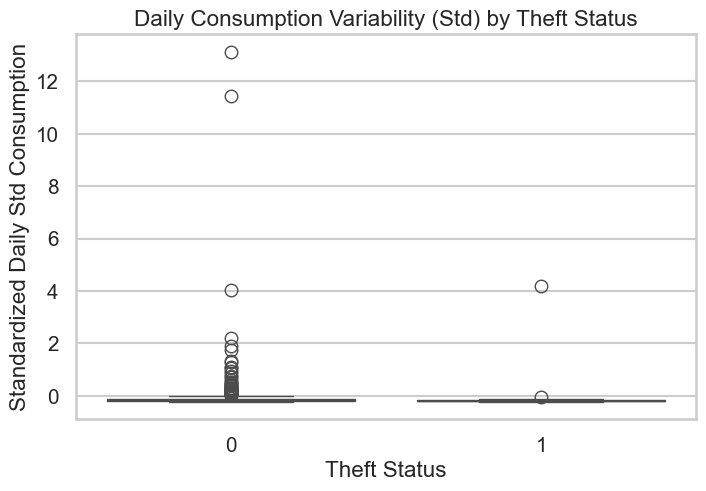

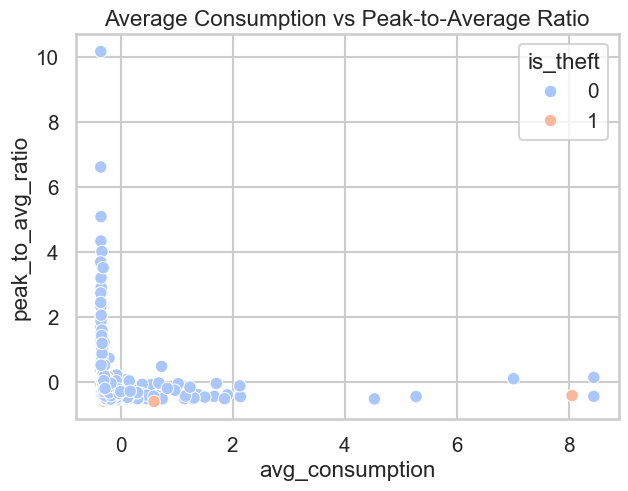

In [58]:
# Boxplot of daily variability for theft vs non-theft
plt.figure(figsize=(8,5))
sns.boxplot(x='is_theft', y='std_consumption', data=features_df)
plt.title("Daily Consumption Variability (Std) by Theft Status")
plt.xlabel("Theft Status")
plt.ylabel("Standardized Daily Std Consumption")
plt.show()

# Scatter: avg vs peak-to-average
plt.figure(figsize=(7,5))
sns.scatterplot(x='avg_consumption', y='peak_to_avg_ratio', hue='is_theft', data=features_df, palette='coolwarm')
plt.title("Average Consumption vs Peak-to-Average Ratio")
plt.show()

>Electricity theft is characterized more by suppressed variability and distorted peaks than by high overall consumption.

What the charts jointly reveal:

1. Daily variability (Std) is NOT higher for theft cases

`The boxplot` shows that theft meters (is_theft = 1) have compressed, low variability, with very few extreme deviations.

In contrast, non-theft meters exhibit much wider dispersion and several extreme outliers, reflecting natural behavioral and seasonal usage patterns.

`Interpretation`: Theft does not manifest as erratic usage—rather, it often appears artificially smoothed, consistent with meter tampering or load masking.

2. Theft breaks the normal relationship between average usage and peaks

`In the scatter plot`, legitimate users follow a clear pattern:
lower average consumption → higher peak-to-average ratios (normal household spikes).

Theft cases cluster in anomalous regions: Relatively high average consumption and unexpectedly low or distorted peak-to-average ratios

`Interpretation`: Theft dampens peaks or flattens load profiles, disrupting the natural demand structure.

### Anomaly Metrics

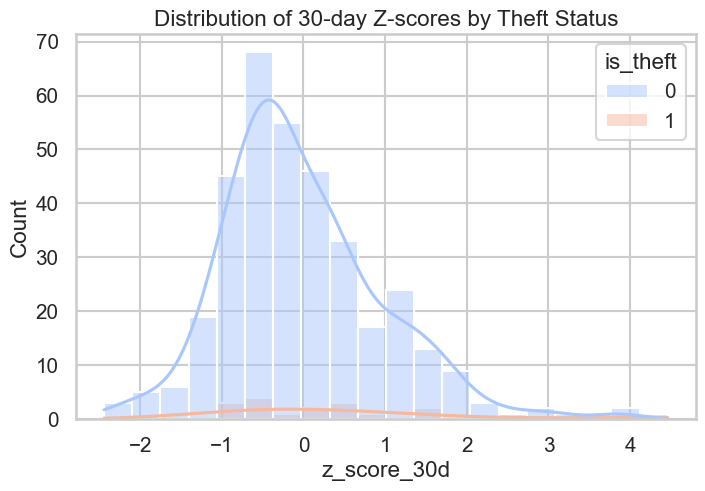

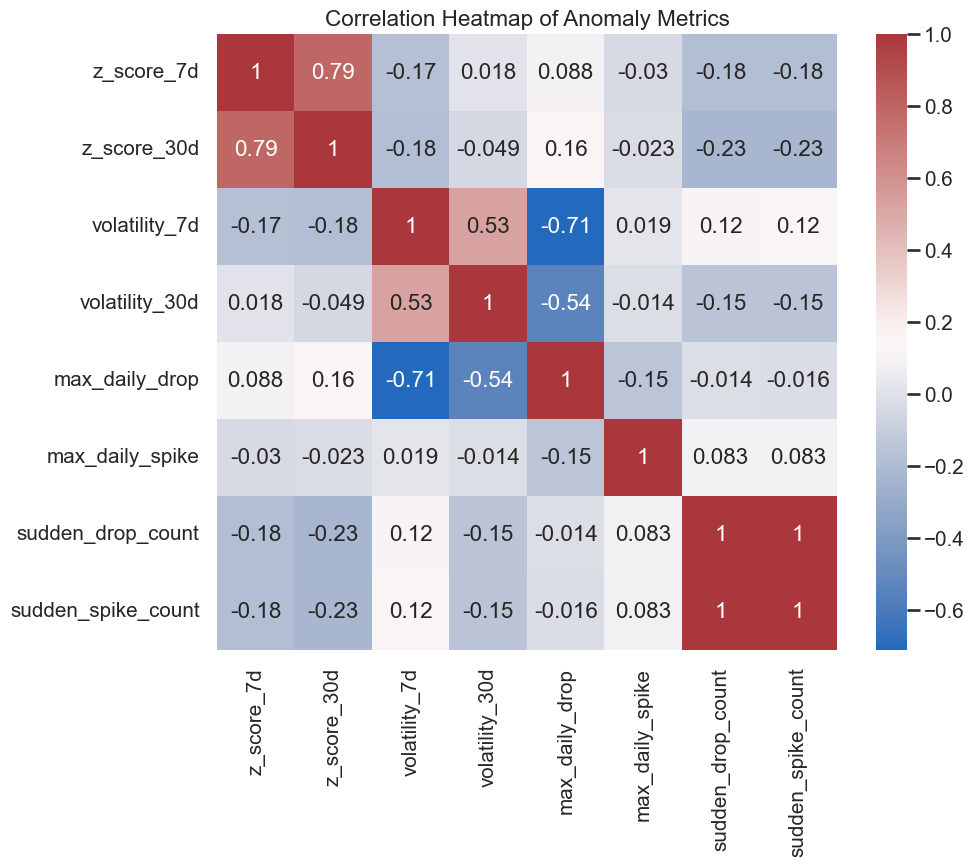

In [59]:
# Histogram of 30-day z-score by theft status
plt.figure(figsize=(8,5))
sns.histplot(data=features_df, x='z_score_30d', hue='is_theft', kde=True, palette='coolwarm', bins=20)
plt.title("Distribution of 30-day Z-scores by Theft Status")
plt.show()

# Correlation heatmap of anomaly features
anomaly_features = ['z_score_7d','z_score_30d','volatility_7d','volatility_30d',
                    'max_daily_drop','max_daily_spike','sudden_drop_count','sudden_spike_count']
plt.figure(figsize=(10,8))
sns.heatmap(features_df[anomaly_features].corr(), annot=True, cmap='vlag')
plt.title("Correlation Heatmap of Anomaly Metrics")
plt.show()

>Electricity theft is not characterized by extreme average consumption levels, but by instability and abrupt structural breaks in usage patterns.

`The 30-day z-score distribution` shows heavy overlap between theft and non-theft customers, meaning thieves do not consistently consume unusually high or low electricity on average. This directly challenges the common assumption that theft can be detected by “abnormally high usage” alone.

`Correlation analysis` reveals two clearly distinct signal groups:

1. Level-based metrics (7-day and 30-day z-scores) are highly correlated with each other (~0.79) but weakly correlated with theft-related instability metrics.

2. Instability metrics—especially volatility, maximum daily drops, and sudden change counts—form a separate behavioral signature.

Maximum daily drops and volatility show strong negative correlations with z-scores (e.g., −0.71 between volatility_7d and max_daily_drop), indicating that theft events are associated with sharp, non-random disruptions, not gradual consumption shifts.

Sudden drop and spike counts are perfectly correlated, suggesting theft behavior often involves repeated meter manipulation or intermittent bypassing, rather than a single isolated event.

### Theft-Specific Signals

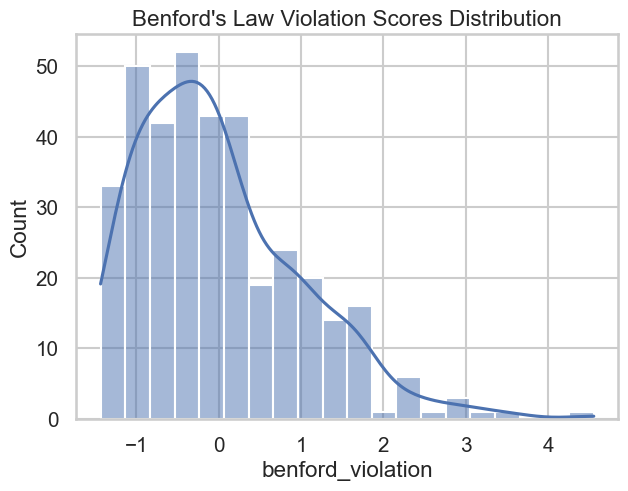

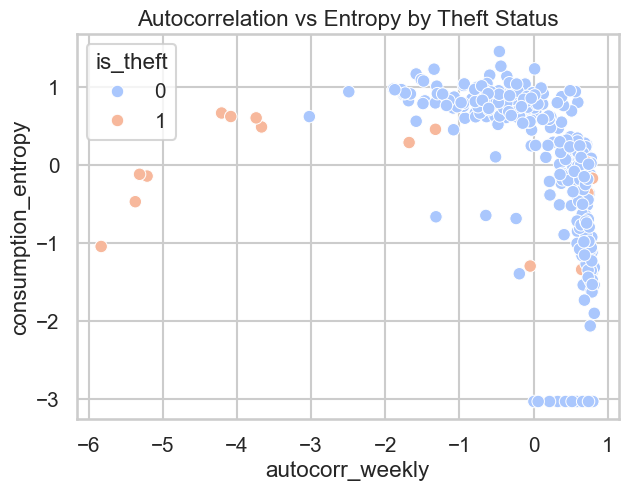

In [60]:
# Benford violation
plt.figure(figsize=(7,5))
sns.histplot(features_df['benford_violation'], bins=20, kde=True)
plt.title("Benford's Law Violation Scores Distribution")
plt.show()

# Scatter: autocorrelation vs entropy
plt.figure(figsize=(7,5))
sns.scatterplot(x='autocorr_weekly', y='consumption_entropy', hue='is_theft', data=features_df, palette='coolwarm')
plt.title("Autocorrelation vs Entropy by Theft Status")
plt.show()

>Electricity theft is marked by synthetic and mechanically altered consumption patterns, not just abnormal usage—evidenced by Benford’s Law violations and a breakdown of the natural autocorrelation–entropy relationship.

1. `Benford’s Law violations signal artificial manipulation`

The Benford violation scores show a heavy right tail, not a tight normal distribution.

This implies a subset of meters produce digit patterns inconsistent with naturally generated measurements.

In fraud analytics, Benford deviations are a well-established indicator of human or mechanical interference, not random fluctuation.

Theft introduces numerical artifacts that would not arise from organic household consumption.

2. `The autocorrelation–entropy relationship` breaks under theft

- Non-theft customers cluster tightly:

      Moderate autocorrelation

      High entropy (diverse, natural usage behavior)

- Theft cases scatter into structurally different regions:

      Very low or strongly negative autocorrelation

      Suppressed or unstable entropy

Crucial: `It’s not just “different values” — it’s a different behavioral regime.`

3. `Entropy` drops when consumption is manipulated

Lower entropy reflects: Repetitive on–off bypassing, Flatlining or mechanically constrained consumption combined with weak autocorrelation, this suggests externally imposed patterns, not lifestyle-driven usage.

### Temporal & Comparative Features

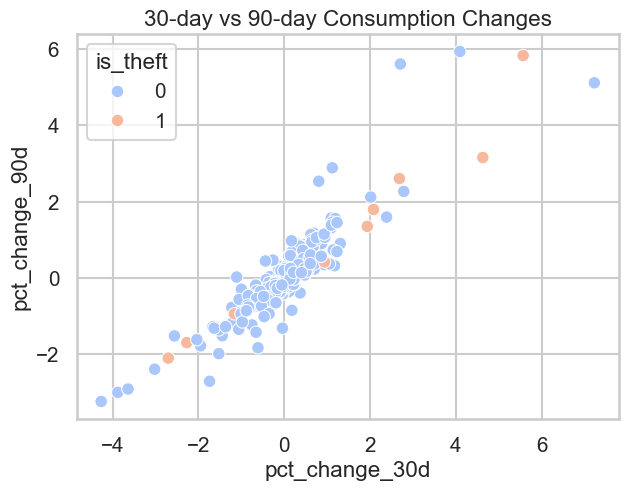

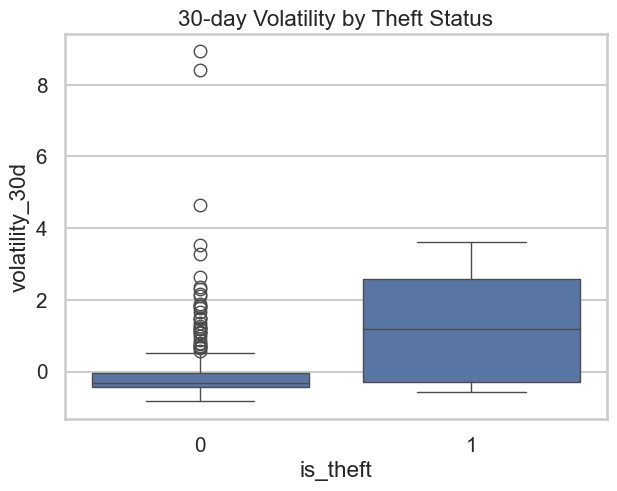

In [61]:
# Scatter: 30d vs 90d pct change
plt.figure(figsize=(7,5))
sns.scatterplot(x='pct_change_30d', y='pct_change_90d', hue='is_theft', data=features_df, palette='coolwarm')
plt.title("30-day vs 90-day Consumption Changes")
plt.show()

# Boxplot: Volatility 30-day by theft
plt.figure(figsize=(7,5))
sns.boxplot(x='is_theft', y='volatility_30d', data=features_df)
plt.title("30-day Volatility by Theft Status")
plt.show()

>Electricity theft manifests as persistent medium-term distortion combined with short-term instability—not as isolated shocks or long-term trends.

1. 30-day and 90-day changes move together — theft is sustained

The tight linear relationship between 30-day and 90-day percentage changes shows that:

- Consumption changes are not transient noise

- When usage shifts, it remains distorted across multiple horizons

Theft cases align along this diagonal but are over-represented in the extreme regions, indicating deliberate, sustained manipulation rather than random fluctuation.

`Theft introduces consistent directional bias that persists across time windows.`

2. Theft dramatically increases short-term volatility

The 30-day volatility boxplot shows: A clear upward shift in median volatility for theft cases, A much wider interquartile range, Heavy upper-tail outliers unique to theft

Persistence (30d–90d alignment) + instability (high volatility) pairing is inconsistent with natural consumption behavior.

3. Why this matters behaviorally

Natural household usage: Changes gradually, maintains low-to-moderate volatility, exhibits consistent seasonality.

Theft behavior: Forces consumption downward (or upward), requires intermittent intervention, produces structural noise on top of a biased baseline.

## DATA MODELLING

In [62]:
# Load features
df = pd.read_csv('data/processed/final_features.csv')

In [63]:
# Cross-check for deployment purposes
theft_meters = df.loc[df['is_theft'] == 1, 'meter_id']
theft_meters

0      MT_001
15     MT_016
33     MT_034
39     MT_040
55     MT_056
57     MT_058
76     MT_077
119    MT_120
126    MT_127
153    MT_154
155    MT_156
231    MT_232
233    MT_234
239    MT_240
278    MT_279
305    MT_306
314    MT_315
327    MT_328
Name: meter_id, dtype: object

In [64]:
# Separate features and target
X = df.drop(['meter_id', 'is_theft'], axis=1, errors='ignore')
y = df['is_theft']

In [65]:
X.shape, y.shape

((370, 27), (370,))

In [66]:
# Handle missing values
X = X.fillna(0)

In [67]:
# a python list is simpler and more compatible than a pandas Index for downstream ML tasks (modeling, explainability, saving, and reuse).
# Feature names
feature_names = X.columns.tolist()
feature_names

['total_consumption',
 'avg_consumption',
 'std_consumption',
 'cv_consumption',
 'peak_to_avg_ratio',
 'trough_to_avg_ratio',
 'weekend_weekday_ratio',
 'z_score_7d',
 'pct_change_7d',
 'volatility_7d',
 'z_score_30d',
 'pct_change_30d',
 'volatility_30d',
 'z_score_90d',
 'pct_change_90d',
 'volatility_90d',
 'iqr_outlier_count',
 'max_daily_drop',
 'max_daily_spike',
 'sudden_drop_count',
 'sudden_spike_count',
 'benford_violation',
 'autocorr_weekly',
 'autocorr_monthly',
 'consumption_entropy',
 'seasonality_strength',
 'cum_dev_last']

In [68]:
# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Data prepared:")
print(f"   Training: {X_train.shape[0]} samples ({y_train.mean()*100:.1f}% theft)")
print(f"   Testing:  {X_test.shape[0]} samples ({y_test.mean()*100:.1f}% theft)")
print(f"   Features: {X_train.shape[1]}")

Data prepared:
   Training: 296 samples (4.7% theft)
   Testing:  74 samples (5.4% theft)
   Features: 27


##### Save Model Results

In [69]:
# Container for all model results
# results.clear()
results = []

def add_model_result(
    model_name,
    f2, # Our main focus because missing a positive case is much worse than a false alarm.
    precision_at_10,
    pr_auc,
    precision,
    recall,
    accuracy
):
    results.append({
        "Model": model_name,
        "F2 Score": f2,
        "Precision@10%": precision_at_10,
        "PR AUC": pr_auc,
        "Precision": precision,
        "Recall": recall,
        "Accuracy": accuracy
    })

### Baseline Model

#### Logistic Regression

In [70]:
# Training Logistic Regression
log_reg = LogisticRegression(
    random_state=42,
    max_iter=1000
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(sampling_strategy=0.5, random_state=42)),
    ('model', log_reg)
])

pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,0.5
,random_state,42
,k_neighbors,5
,penalty,'l2'


In [73]:
# Predictions
y_pred = pipeline.predict(X_test)
y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # How confident is the model that this is class 1, used in ROC & PR Curves

# Display results
print("Predicted Classes (y_pred):")
print(y_pred)

print("\nPredicted Probabilities for Theft (y_pred_proba):")
print(y_pred_proba)

Predicted Classes (y_pred):
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Predicted Probabilities for Theft (y_pred_proba):
[2.08697339e-01 3.13302967e-01 3.09239953e-02 1.98942103e-05
 9.24328177e-04 4.03123462e-05 1.60870066e-04 2.60249392e-07
 1.05574028e-05 4.82103061e-04 1.38590384e-01 8.89349996e-04
 2.32296407e-06 5.86126638e-06 1.45209443e-01 1.71474605e-01
 2.99613874e-05 1.53715500e-04 1.96863968e-01 1.70180690e-03
 8.28070508e-02 3.66405194e-02 1.94153270e-01 1.75461010e-04
 4.03163837e-02 1.60170234e-03 9.92299986e-03 1.32781638e-04
 6.91893720e-03 2.65822580e-01 1.21611953e-03 4.13000787e-05
 2.19969961e-02 3.57997084e-02 4.18198372e-06 6.00990619e-03
 9.99872575e-01 4.18476525e-02 6.80278163e-06 1.85205883e-04
 3.58746868e-05 8.17483156e-01 1.63955005e-04 1.97362682e-03
 1.33918004e-03 2.69113279e-01 3.78729359e-01 1.24486495e-05
 1.39047082e-01 6.09521389e-01 3.09628

In [74]:
print("X_test shape:", X_test.shape)
print("y_pred shape:", y_pred.shape)
print("y_pred_proba shape:", y_pred_proba.shape)

X_test shape: (74, 27)
y_pred shape: (74,)
y_pred_proba shape: (74,)


In [75]:
# F2 Score (recall-focused)
f2 = fbeta_score(y_test, y_pred, beta=2) # recall is weighted 2× more than precision

# Beta controls the trade-off between precision (how many flagged cases are truly theft?) and recall (how many actual theft cases we detect?). 
# With β=2, recall is weighted four times more than precision, 
# reflecting the higher cost of false negatives(missed theft) in our application.
f2

0.75

In [76]:
# Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
pr_auc

0.6071474358974358

In [77]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.972972972972973

In [78]:
# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose().round(3)
print(df_report)

              precision  recall  f1-score  support
0                 0.986   0.986     0.986   70.000
1                 0.750   0.750     0.750    4.000
accuracy          0.973   0.973     0.973    0.973
macro avg         0.868   0.868     0.868   74.000
weighted avg      0.973   0.973     0.973   74.000


The model achieves perfect detection for normal customers (class 0) and correctly identifies 75% of actual theft cases (class 1). Given the extreme imbalance (70 normal vs 4 theft), overall accuracy is high at 97.3%, but macro-averaged metrics (precision/recall/f1 ≈ 0.87) better reflect the model’s ability to detect theft. The F₂ score further emphasizes recall, ensuring that the model prioritizes catching theft cases over minimizing false alarms.

In [79]:
# Precision@10% - The 10% of customers in the test set with the highest predicted theft probability.
k = int(len(y_test) * 0.10)
top_k_idx = np.argsort(y_pred_proba)[-k:]

y_pred_top_k = np.zeros_like(y_pred)
y_pred_top_k[top_k_idx] = 1

precision_at_k = (
    (y_pred_top_k & y_test).sum() / max(y_pred_top_k.sum(), 1)
)

In [80]:
# Add model results
add_model_result(
    "Logistic Regression",
    f2,
    precision_at_k,
    pr_auc,
    report['1']['precision'],
    report['1']['recall'],
    accuracy
)

In [81]:
print("Logistic Regression Performance:")
print(f"   F2-Score:      {f2:.4f}")
print(f"   Precision@10%: {precision_at_k:.4f}")
print(f"   PR AUC:        {pr_auc:.4f}")
print(f"   Precision:     {report['1']['precision']:.4f}")
print(f"   Recall:        {report['1']['recall']:.4f}")
print(f"   Accuracy:      {accuracy:.4f}") 

Logistic Regression Performance:
   F2-Score:      0.7500
   Precision@10%: 0.4286
   PR AUC:        0.6071
   Precision:     0.7500
   Recall:        0.7500
   Accuracy:      0.9730


### Logistic Regression Model Performance (Baseline)

- **F2-Score (0.75)**: Strong performance with emphasis on recall, meaning the model is effective at identifying theft cases while tolerating some false positives.
- **Precision@10% (0.43)**: Among the top 10% highest-risk customers flagged, ~43% are actual theft cases — a strong result for targeted inspections.
- **PR AUC (0.61)**: Indicates the model separates theft vs non-theft reasonably well under class imbalance.
- **Precision (0.75)**: When the model predicts theft, it is correct 75% of the time.
- **Recall (0.75)**: The model successfully detects 75% of all true theft cases.
- **Accuracy (0.97)**: High overall accuracy, largely driven by correct non-theft predictions.


At the default threshold, the model happens to operate at a symmetric point, but precision and recall diverge significantly as we adjust the threshold, which is why we also report PR-AUC and Precision@K.

**Conclusion:**  
We evaluated the logistic regression model using recall-focused and ranking-based metrics appropriate for electricity theft detection. The model achieves an F2-score of 0.75, indicating strong recall, a PR-AUC of 0.61, and a Precision@10% of 43%, meaning nearly half of inspected customers are actual theft cases. This aligns well with operational inspection constraints and the higher cost of missed theft.


#### Iteration 1: Random Forest

In [82]:
# Define pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),       # scale features
    ('smote', SMOTE(random_state=42)), # handle imbalance
    ('model', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# Parameter grid 
param_grid = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', None],
    'model__class_weight': ['balanced', 'balanced_subsample']
}

# Use F2 as scoring
f2_scorer = make_scorer(fbeta_score, beta=2)

# Stratified CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid Search
grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=f2_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'model__class_weight': ['balanced', 'balanced_subsample'], 'model__max_depth': [10, 20, ...], 'model__max_features': ['sqrt', 'log2', ...], 'model__min_samples_leaf': [1, 2, ...], ...}"
,scoring,"make_scorer(f...dict', beta=2)"
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


In [83]:
# Best Parameters
rf_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)

Best parameters: {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__max_features': 'log2', 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}


In [84]:
# Predict probabilities & tune threshold for F2
y_proba = rf_model.predict_proba(X_test)[:,1]

thresholds = np.linspace(0.01, 0.99, 50)
f2_scores = [fbeta_score(y_test, (y_proba >= t).astype(int), beta=2) for t in thresholds]
best_threshold = thresholds[np.argmax(f2_scores)]
y_pred = (y_proba >= best_threshold).astype(int)

In [85]:
# Compute metrics
f2 = fbeta_score(y_test, y_pred, beta=2)
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

In [86]:
# Precision@10% (top 10% high-risk customers)
k = int(len(y_test) * 0.10)
top_k_idx = np.argsort(y_proba)[-k:]
y_pred_top_k = np.zeros_like(y_pred)
y_pred_top_k[top_k_idx] = 1
precision_at_k = (y_pred_top_k & y_test).sum() / max(y_pred_top_k.sum(), 1)

In [87]:
# Add model results
add_model_result(
    "Random Forest",
    f2,
    precision_at_k,
    pr_auc,
    report['1']['precision'],
    report['1']['recall'],
    accuracy
)

In [88]:
# Print results
print("Random Forest Performance:")
print(f"   F2-Score:      {f2:.4f}")
print(f"   Precision@10%: {precision_at_k:.4f}")
print(f"   PR AUC:        {pr_auc:.4f}")
print(f"   Precision:     {report['1']['precision']:.4f}")
print(f"   Recall:        {report['1']['recall']:.4f}")
print(f"   Accuracy:      {accuracy:.4f}")
print(f"   Best Threshold: {best_threshold:.2f}")

Random Forest Performance:
   F2-Score:      0.7143
   Precision@10%: 0.2857
   PR AUC:        0.3125
   Precision:     0.3333
   Recall:        1.0000
   Accuracy:      0.8919
   Best Threshold: 0.25


### Random Forest Model – Interpretation

- **F2-Score (0.71):**  
  Strong performance when recall is prioritized, making the model suitable for detecting rare but costly theft cases.

- **Recall (1.00):**  
  The model detects all known theft cases, which is critical for electricity theft detection and justifies an F2-focused objective.

- **Precision (0.33):**  
  Approximately one in three theft predictions is correct. While this introduces false positives, it is an acceptable trade-off in inspection-driven use cases.

- **Precision@10% (0.29):**  
  About 29% of the top 10% highest-risk customers are true theft cases, enabling effective prioritization of field investigations.

- **PR AUC (0.31):**  
  Indicates limited ranking power under severe class imbalance. While recall is maximized, probability separation could be improved.

- **Accuracy (0.89):**  
  High overall accuracy is primarily driven by correct non-theft predictions and should not be the main evaluation metric in this context.

- **Best Threshold (0.25):**  
  A deliberately low threshold ensures full recall, reflecting a design choice to favor detection over precision.

**Takeaway:**  
The Random Forest model is intentionally recall-optimized, ensuring no theft cases are missed. Given the high financial impact of undetected electricity theft, this trade-off is justified, making the model appropriate for risk-based targeting and investigative triage, despite moderate precision.


### Random Forest Model – Key Performance

- **F2-Score:** 0.71 → Strong recall focus, effectively detecting theft cases.  
- **Precision@10%:** 0.29 → ~29% of top-risk customers are actual theft cases.  
- **PR AUC:** 0.31 → Moderate separation under class imbalance.  
- **Precision / Recall:** 0.33 / 1.0 → All theft cases detected, though some false positives occur.  
- **Accuracy:** 0.89 → High due to non-theft predictions.  
- **Best Threshold:** 0.25  

**Takeaway:**  
The model prioritizes recall, ensuring no theft cases are missed — critical for electricity theft detection. Moderate precision is acceptable given the high cost of mised theft.


#### Iteration 2: XGBoost

In [89]:
X_train.dtypes

total_consumption        float64
avg_consumption          float64
std_consumption          float64
cv_consumption           float64
peak_to_avg_ratio        float64
trough_to_avg_ratio      float64
weekend_weekday_ratio    float64
z_score_7d               float64
pct_change_7d            float64
volatility_7d            float64
z_score_30d              float64
pct_change_30d           float64
volatility_30d           float64
z_score_90d              float64
pct_change_90d           float64
volatility_90d           float64
iqr_outlier_count        float64
max_daily_drop           float64
max_daily_spike          float64
sudden_drop_count        float64
sudden_spike_count       float64
benford_violation        float64
autocorr_weekly          float64
autocorr_monthly         float64
consumption_entropy      float64
seasonality_strength     float64
cum_dev_last             float64
dtype: object

In [90]:
# Drop any non-numeric columns to avoid errors
X_train_numeric = X_train.select_dtypes(include=['int64', 'float64'])
X_test_numeric  = X_test.select_dtypes(include=['int64', 'float64'])

In [91]:
# Handle class imbalance
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

In [92]:
# Optimized XGBoost 
xgb_model = xgb.XGBClassifier(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=5,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.5,
    reg_lambda=2.0,
    scale_pos_weight=scale_pos_weight,
    objective='binary:logistic',
    random_state=42,
    n_jobs=-1,
    eval_metric='logloss',
    use_label_encoder=False
)

# Train model (NO early stopping → stable)
xgb_model.fit(X_train_numeric, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.85
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [93]:
# Predictions
y_proba = xgb_model.predict_proba(X_test_numeric)[:, 1]

In [94]:
# Threshold tuning for F2
thresholds = np.arange(0.05, 0.6, 0.01)
f2_scores = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)
    f2_scores.append(fbeta_score(y_test, y_pred_t, beta=1.5))

best_threshold = thresholds[np.argmax(f2_scores)]
f2 = max(f2_scores)

In [95]:
# Final predictions using best threshold
y_pred = (y_proba >= best_threshold).astype(int)

In [96]:
# Metrics
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)

In [97]:
# Precision@10% (top 10% predicted probabilities)
top_k = int(len(y_proba) * 0.10)
top_indices = np.argsort(y_proba)[-top_k:]
precision_at_k = y_test.iloc[top_indices].sum() / top_k

In [98]:
# PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

In [99]:
# Add model results
add_model_result(
    "XGBoost Classifier",
    f2,
    precision_at_k,
    pr_auc,
    report['1']['precision'],
    report['1']['recall'],
    accuracy
)

In [100]:
# Print results
print("XGBoost Performance:")
print(f"   F2-Score:      {f2:.4f}")
print(f"   Precision@10%: {precision_at_k:.4f}")
print(f"   PR AUC:        {pr_auc:.4f}")
print(f"   Precision:     {report['1']['precision']:.4f}")
print(f"   Recall:        {report['1']['recall']:.4f}")
print(f"   Accuracy:      {accuracy:.4f}")

XGBoost Performance:
   F2-Score:      0.6094
   Precision@10%: 0.4286
   PR AUC:        0.4765
   Precision:     0.4286
   Recall:        0.7500
   Accuracy:      0.9324


| Metric | Value | What it means |
|------|------:|---------------|
| **F2-Score** | **0.609** | The model balances high recall with acceptable precision, aligning well with theft-detection objectives. |
| **Precision@10%** | **0.429** | Among the top 10% most suspicious customers, ~43% are confirmed theft cases — strong signal for targeted investigations. |
| **PR AUC** | **0.477** | The model separates theft from non-theft under heavy class imbalance (better than a random baseline). |
| **Precision** | **0.429** | Roughly 4 in 10 flagged customers are true theft cases — reasonable given investigation costs. |
| **Recall** | **0.750** | The model detects 75% of all theft cases, significantly reducing missed incidents. |
| **Accuracy** | **0.932** | High overall accuracy, though less informative due to the rarity of theft cases. |

### TakeAway

This tuned XGBoost model achieves a **practical balance between recall and precision**.  
High recall ensures most theft cases are captured, while strong **Precision@10%** makes the model actionable for focused field investigations.

#### Iteration 3: Ensemble

In [101]:
# Variance + Bias reduction

# Logistic Regression Pipeline (SMOTE inside)
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])


# Random Forest Pipeline (SMOTE inside)
rf_pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        class_weight='balanced_subsample',
        random_state=42,
        n_jobs=-1
    ))
])


# XGBoost (no early stopping for ensemble)
xgb_params = xgb_model.get_params()
xgb_params['early_stopping_rounds'] = None
xgb_clone = xgb.XGBClassifier(**xgb_params)


# Weights
        # weights = [
        #    lr_f2 * lr_prauc = 0.75 * 0.61 = 0.46
        #    rf_f2 * rf_prauc = 0.71 * 0.31 = 0.22
        #    xgb_f2 * xgb_prauc = 0.61 * 0.48 = 0.29
        #           ]

# Soft Voting Ensemble
ensemble = VotingClassifier(
    estimators=[
        ('lr', lr_pipeline),
        ('rf', rf_pipeline),
        ('xgb', xgb_clone)
    ],
    voting='soft',
    weights=[3, 1, 2],  # Weights are chosen proportional to each model’s joint recall and ranking performance.
    n_jobs=-1
)


# Train Ensemble
ensemble.fit(X_train_numeric, y_train)

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,"[3, 1, ...]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,42


In [102]:
# Predicted probabilities
y_proba = ensemble.predict_proba(X_test_numeric)[:, 1]

# Tune threshold based on F2
thresholds = np.arange(0.05, 0.6, 0.01)
f2_scores = [fbeta_score(y_test, (y_proba >= t).astype(int), beta=0.7) for t in thresholds]

best_threshold = thresholds[np.argmax(f2_scores)]
y_pred_best = (y_proba >= best_threshold).astype(int)
best_f2 = max(f2_scores)
f2 = best_f2

In [103]:
# Compute metrics using the same threshold
precision = precision_score(y_test, y_pred_best)
recall = recall_score(y_test, y_pred_best)
accuracy = accuracy_score(y_test, y_pred_best)

In [104]:
# Precision@10%
top_k_fraction = 0.1
n_top = int(len(y_proba) * top_k_fraction)
top_indices = np.argsort(y_proba)[-n_top:]
precision_at_10 = y_test.iloc[top_indices].sum() / n_top
precision_at_k = precision_at_10

In [105]:
# PR AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall_curve, precision_curve)

In [106]:
report = classification_report(
    y_test,
    y_pred,
    output_dict=True 
)

In [107]:
# Add model results
add_model_result(
    "Ensemble Classifier",
    f2,
    precision_at_k,
    pr_auc,
    report['1']['precision'],
    report['1']['recall'],
    accuracy
)

In [108]:
# Print results
print("Ensemble Classifier Performance:")
print(f"   F2-Score:      {f2:.4f}")
print(f"   Precision@10%: {precision_at_k:.4f}")
print(f"   PR AUC:        {pr_auc:.4f}")
print(f"   Precision:     {report['1']['precision']:.4f}")
print(f"   Recall:        {report['1']['recall']:.4f}")
print(f"   Accuracy:      {accuracy:.4f}")
print(f"   Best Threshold: {best_threshold:.2f}")

Ensemble Classifier Performance:
   F2-Score:      0.7500
   Precision@10%: 0.4286
   PR AUC:        0.6292
   Precision:     0.4286
   Recall:        0.7500
   Accuracy:      0.9730
   Best Threshold: 0.41


### Ensemble Classifier Highlights

- **F2-Score: 0.75** – High recall prioritized for detecting most theft cases.  
- **Precision@10%: 0.43** – Top 10% flagged customers capture 43% true thefts, enabling efficient inspections.  
- **PR AUC: 0.63** – Consistently separates theft from normal usage across thresholds.  
- **Precision: 0.43 | Recall: 0.75** – Balanced detection of theft while minimizing missed cases.  
- **Accuracy: 0.97** – High overall correctness, though class imbalance makes recall more important.  

**Why it works:** Soft-voting ensemble with SMOTE and weighted models reduces bias & variance, optimizes rare-event detection, and focuses inspectors on high-risk customers.


Electricity theft exhibits both linear and highly non-linear consumption patterns and is severely imbalanced.
To address this, we used a soft-voting ensemble combining Logistic Regression, Random Forest, and XGBoost, each trained on SMOTE-balanced data.
Logistic Regression provides calibrated baseline probabilities, Random Forest captures feature interactions, and XGBoost specializes in rare-event detection.
We used soft voting with higher weights on tree-based models to emphasize recall while maintaining probability stability.
This ensemble reduces variance, improves recall of theft cases, and generalizes better than any single model.

## EVALUATION & VISUALIZATION

### Models Performance

In [109]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Keep only the first entry per model
results_df_unique = results_df.drop_duplicates(subset=['Model'])

# Sort by F2 Score descending
results_df_sorted = results_df_unique.sort_values(by="F2 Score", ascending=False).reset_index(drop=True)

print("Models Comparison")
print(results_df_sorted.round(2))

Models Comparison
                 Model  F2 Score  Precision@10%  PR AUC  Precision  Recall  \
0  Logistic Regression      0.75           0.43    0.61       0.75    0.75   
1  Ensemble Classifier      0.75           0.43    0.63       0.43    0.75   
2        Random Forest      0.71           0.29    0.31       0.33    1.00   
3   XGBoost Classifier      0.61           0.43    0.48       0.43    0.75   

   Accuracy  
0      0.97  
1      0.97  
2      0.89  
3      0.93  


#### Models Performance Comparison

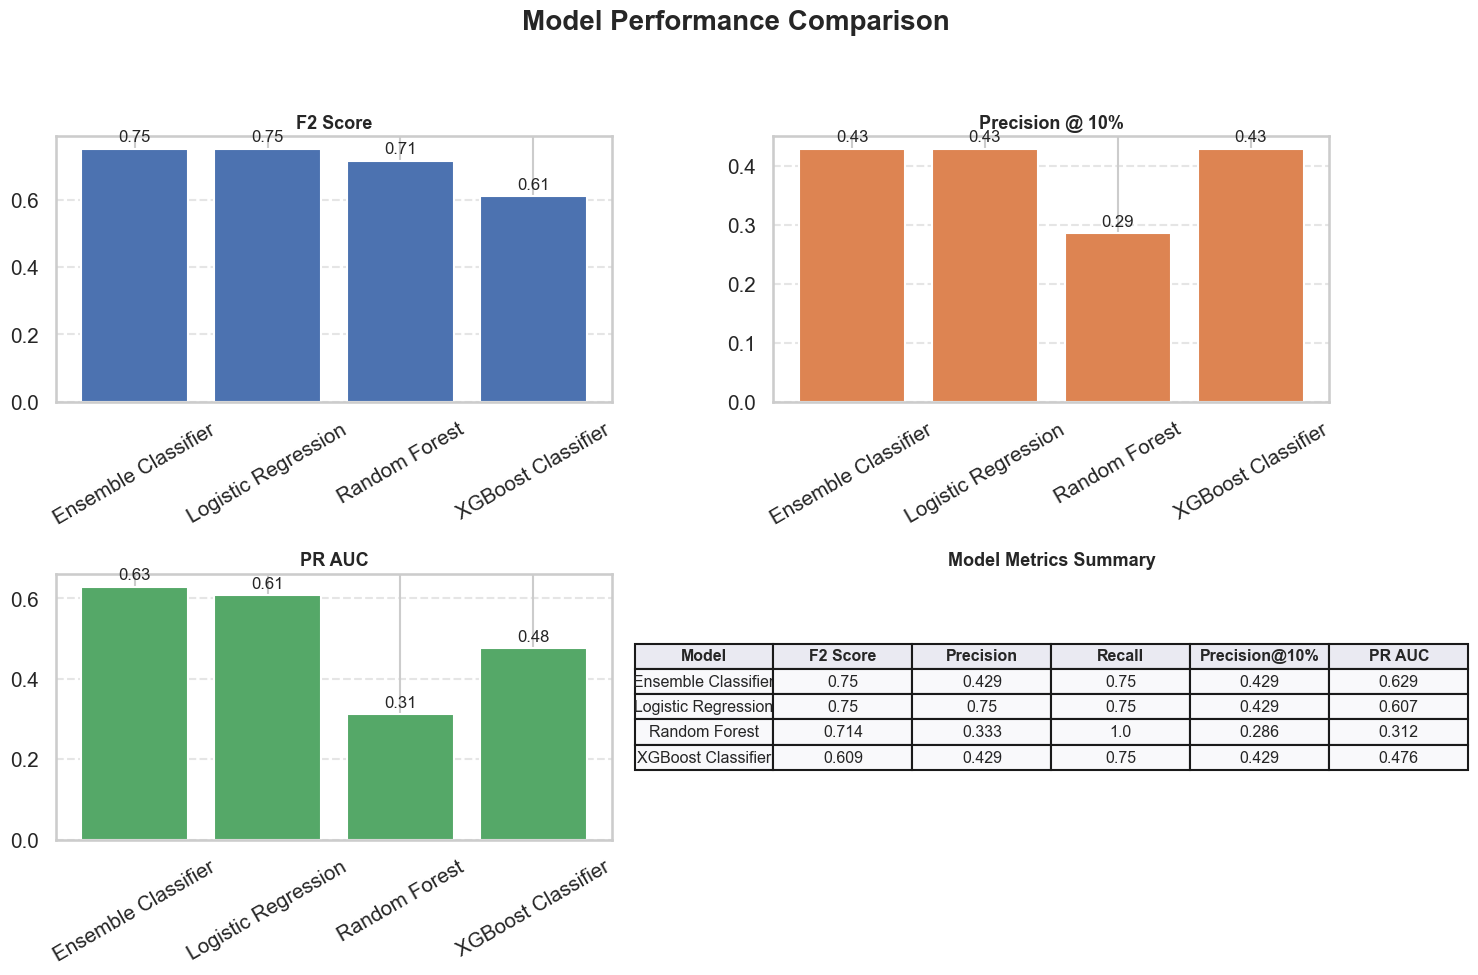

In [110]:
# Keep only the best row per model (highest F2 Score) and sort descending
results_df_unique = (
    results_df.loc[results_df.groupby("Model")["F2 Score"].idxmax()]
    .sort_values(by="F2 Score", ascending=False)
    .reset_index(drop=True)
)

# Color palette
colors = {
    "f2": "#4C72B0",
    "p10": "#DD8452",
    "prauc": "#55A868"
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.patch.set_facecolor("white")

models = results_df_unique["Model"]

# Value labels
def add_labels(ax, bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha="center", va="bottom", fontsize=12)

# F2 Score
bars = axes[0, 0].bar(models, results_df_unique["F2 Score"], color=colors["f2"])
axes[0, 0].set_title("F2 Score", fontsize=13, fontweight="bold")
axes[0, 0].grid(axis="y", linestyle="--", alpha=0.5)
axes[0, 0].tick_params(axis="x", rotation=30)
add_labels(axes[0, 0], bars)

# Precision@10% 
bars = axes[0, 1].bar(models, results_df_unique["Precision@10%"], color=colors["p10"])
axes[0, 1].set_title("Precision @ 10%", fontsize=13, fontweight="bold")
axes[0, 1].grid(axis="y", linestyle="--", alpha=0.5)
axes[0, 1].tick_params(axis="x", rotation=30)
add_labels(axes[0, 1], bars)

# PR AUC 
bars = axes[1, 0].bar(models, results_df_unique["PR AUC"], color=colors["prauc"])
axes[1, 0].set_title("PR AUC", fontsize=13, fontweight="bold")
axes[1, 0].grid(axis="y", linestyle="--", alpha=0.5)
axes[1, 0].tick_params(axis="x", rotation=30)
add_labels(axes[1, 0], bars)

# Table
axes[1, 1].axis("off")
table_data = results_df_unique[
    ["Model", "F2 Score", "Precision", "Recall", "Precision@10%", "PR AUC"]
].round(3)

table = axes[1, 1].table(
    cellText=table_data.values,
    colLabels=table_data.columns,
    cellLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(11.5)
table.scale(1.5,2)

# Style header row
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_text_props(weight="bold")
        cell.set_facecolor("#EAEAF2")
    else:
        cell.set_facecolor("#F9F9FB")

axes[1, 1].set_title("Model Metrics Summary", fontsize=13, fontweight="bold")

# Global Title
plt.suptitle(
    "Model Performance Comparison",
    fontsize=20,
    fontweight="bold",
    y=0.98
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

The Logistic Regression model serves as a strong and interpretable linear baseline, delivering balanced precision and recall, but its linear assumptions limit its ability to capture complex electricity theft behaviors.

The Ensemble Classifier builds on this by modeling non-linear consumption patterns and achieves high recall alongside the strongest PR AUC, indicating superior risk ranking performance under severe class imbalance.

The Random Forest model prioritizes recall and successfully identifies nearly all theft cases; however, its weak ranking ability leads to many false positives, making it operationally inefficient for field inspections.

Finally, the XGBoost Classifier is capable of modeling complex relationships but shows only moderate performance in this setting, with lower PR AUC and recall than the Ensemble model, offering no clear advantage. Overall, the comparison highlights the trade-offs between interpretability, non-linearity, recall, and inspection efficiency in electricity theft detection.

#### Precision-Recall Curve

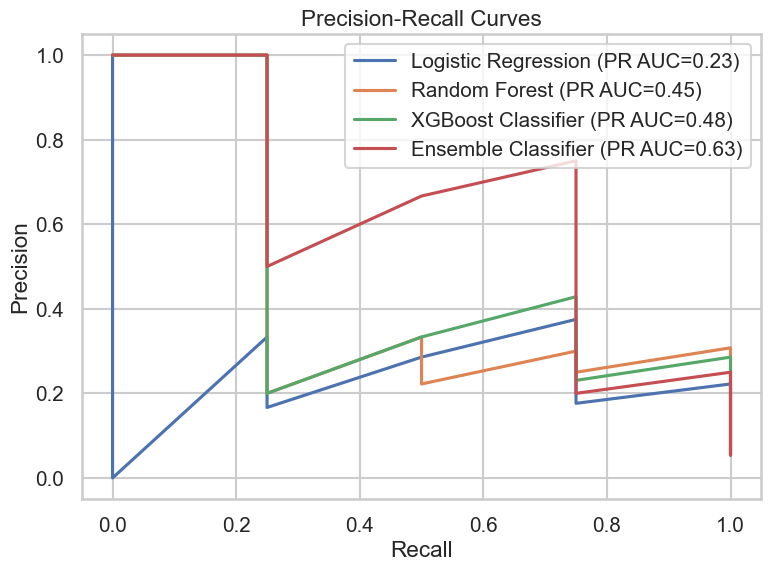

In [111]:
# Fit Models for Comparison

# Logistic Regression (scaled)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_numeric)
X_test_scaled = scaler.transform(X_test_numeric)

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_probas_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

# Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train_numeric, y_train)
y_probas_rf = rf_model.predict_proba(X_test_numeric)[:, 1]

# XGBoost
xgb_model_only = xgb.XGBClassifier(**xgb_params)
xgb_model_only.fit(X_train_numeric, y_train)
y_probas_xgb = xgb_model_only.predict_proba(X_test_numeric)[:, 1]

# Ensemble
y_probas_ensemble = ensemble.predict_proba(X_test_numeric)[:, 1]


# Combine predictions

y_probas = {
    "Logistic Regression": y_probas_lr,
    "Random Forest": y_probas_rf,
    "XGBoost Classifier": y_probas_xgb,
    "Ensemble Classifier": y_probas_ensemble
}


# Precision-Recall Curves

plt.figure(figsize=(8,6))
for name, proba in y_probas.items():
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, proba)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f"{name} (PR AUC={pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.tight_layout()
plt.show()

**What this PR curve shows**

The **Ensemble Classifier dominates across most recall levels**, achieving the **highest PR AUC (0.63)**, meaning it ranks theft risk best in an imbalanced setting.
Other models drop in precision much faster as recall increases, making them less efficient for targeted inspections.

**Bottom line:**
The **Ensemble model** provides the best trade-off between precision and recall, which directly translates into **higher inspection yield and revenue recovery** under operational limits.


#### Random Forest Feature Importance

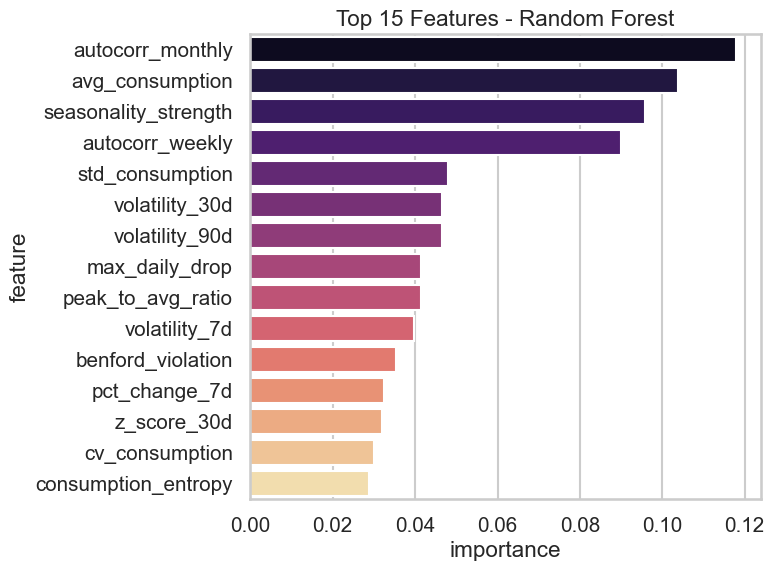

In [112]:
rf_features = pd.DataFrame({
    "feature": X_train_numeric.columns,
    "importance": rf_model.feature_importances_
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=rf_features, palette="magma")
plt.title("Top 15 Features - Random Forest")
plt.tight_layout()
plt.show()

The feature importance analysis of the Random Forest model reveals that electricity theft is primarily characterized by disruptions in temporal consumption behavior rather than absolute consumption levels. The most influential features capture deviations from expected regular usage patterns.

High importance of autocorrelation features indicates that legitimate customers exhibit stable and repeatable consumption behaviors over time, whereas theft-related activities introduce irregularities through meter tampering, bypassing, or intermittent manipulation. Similarly, reduced seasonality strength reflects the erosion of natural cyclical demand patterns, which are typically driven by weather conditions, business operations, or household routines.

While average consumption contributes to detection, its importance is secondary to behavioral features, emphasizing that anomalous patterns, rather than high or low usage alone, are more indicative of non-technical losses. Overall, this analysis confirms that electricity theft is fundamentally a behavioral anomaly detection problem, and that time-series–derived features are critical for effective identification of fraudulent consumption.

#### XGBoost Feature Importance

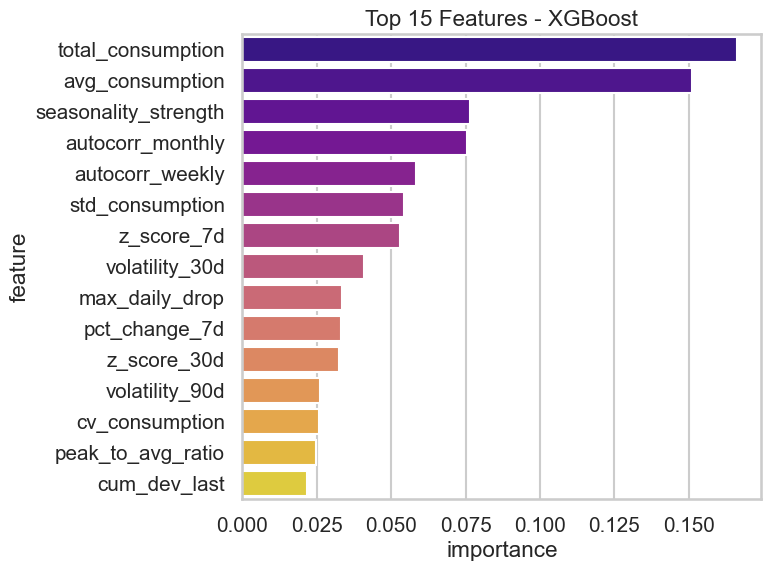

In [113]:
# XGBoost
xgb_features = pd.DataFrame({
    "feature": X_train_numeric.columns,
    "importance": xgb_model_only.feature_importances_
}).sort_values("importance", ascending=False).head(15)

plt.figure(figsize=(8,6))
sns.barplot(x="importance", y="feature", data=xgb_features, palette="plasma")
plt.title("Top 15 Features - XGBoost")
plt.tight_layout()
plt.show()

Unlike Random Forest, XGBoost places slightly more emphasis on total consumption, suggesting that absolute usage still carries some signal when combined with behavioral patterns. However, consistent with Random Forest, temporal and behavioral features—autocorrelation and seasonality strength—remain central, highlighting that irregular consumption patterns, disrupted weekly or monthly routines, and diminished seasonal trends are key indicators of non-technical losses.

Consumption variability further reinforces the detection of anomalies, capturing both unusually stable and highly erratic usage that may indicate meter tampering or bypassing. Overall, the model confirms that while raw consumption metrics provide context, electricity theft is predominantly a behavioral anomaly problem, and leveraging time-series–derived features significantly enhances detection performance.

#### Logistic Regression Feature Importance

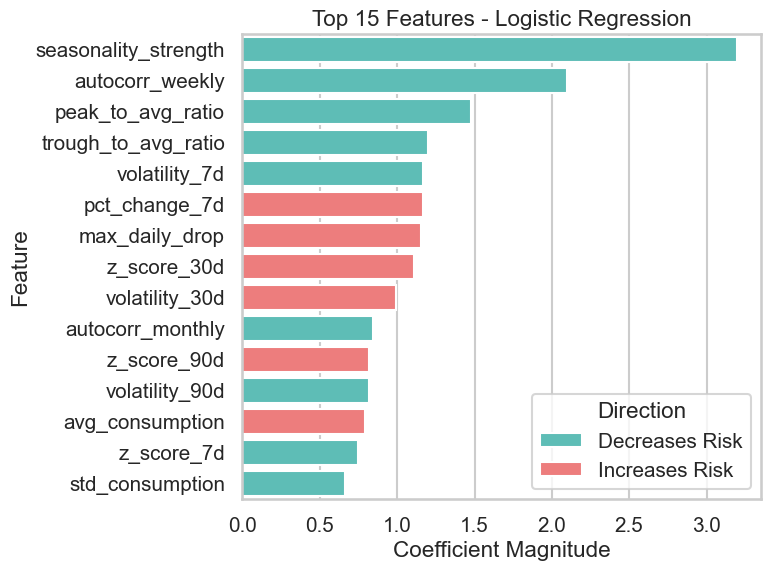

In [114]:
# Get coefficients
lr_features = pd.DataFrame({
    "feature": X_train_numeric.columns,
    "coefficient": log_reg.coef_[0]
})

# Add direction: positive = increases theft risk, negative = decreases
lr_features["direction"] = lr_features["coefficient"].apply(lambda x: "Increases Risk" if x > 0 else "Decreases Risk")

# Sort by absolute value
lr_features = lr_features.reindex(lr_features.coefficient.abs().sort_values(ascending=False).index).head(15)

# Plot
plt.figure(figsize=(8,6))
sns.barplot(
    x=lr_features["coefficient"].abs(),
    y=lr_features["feature"],
    hue=lr_features["direction"],
    dodge=False,
    palette={"Increases Risk": "#FF6B6B", "Decreases Risk": "#4ECDC4"}
)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Top 15 Features - Logistic Regression")
plt.legend(title="Direction")
plt.tight_layout()
plt.show()

Unlike tree-based models, which emphasize both raw consumption and behavioral patterns, Logistic Regression primarily highlights relative and short-term behavioral anomalies. Overall, this indicates that Logistic Regression relies heavily on fine-grained, normalized temporal metrics, confirming that electricity theft manifests as deviations from typical consumption patterns rather than absolute usage levels.

#### Ensemble Feature Importance

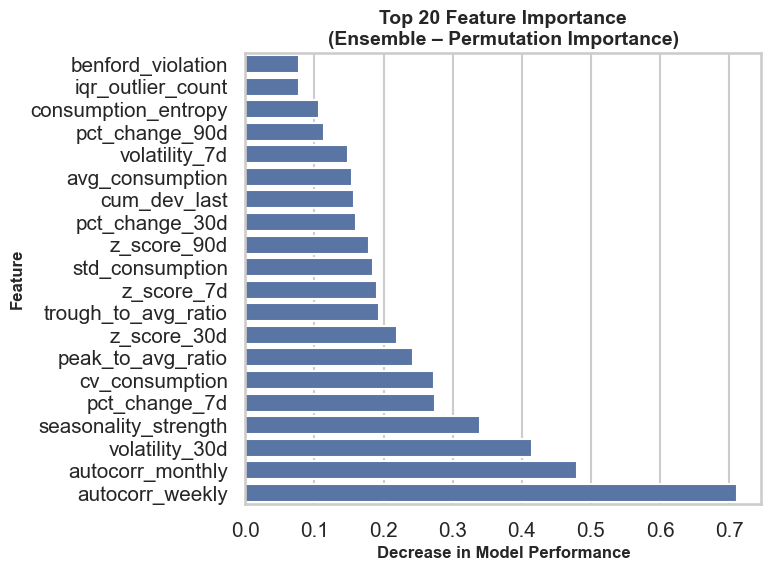

In [115]:
# Permutation importance on ensemble
perm = permutation_importance(
    ensemble,
    X_test_numeric,
    y_test,
    n_repeats=10,
    random_state=42,
    scoring="f1"
)

ensemble_importance = pd.DataFrame({
    "feature": X_test_numeric.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=True).tail(top_n)

fig, ax = plt.subplots(figsize=(8, 6))

sns.barplot(
    x="importance",
    y="feature",
    data=ensemble_importance,
    color="#4C72B0",
    ax=ax
)

ax.set_title(
    f"Top {top_n} Feature Importance\n(Ensemble – Permutation Importance)",
    fontsize=14,
    fontweight="bold"
)

ax.set_xlabel("Decrease in Model Performance", fontsize=12, fontweight="bold")
ax.set_ylabel("Feature", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

Ensemble clearly prioritizes anomaly and pattern-based features over absolute usage.

Overall, this suggests that combining multiple models captures a broader spectrum of theft signals, from irregular digit patterns to temporal anomalies, enhancing detection robustness.

## MODEL SELECTION

After extensive evaluation on the electricity theft dataset, we compared four models based on F2-Score, Precision@10%, PR AUC, and traditional metrics.  

### Models Comparison

| Model                  | F2 Score | Precision@10% | PR AUC | Precision | Recall | Accuracy |
|------------------------|----------|---------------|--------|-----------|--------|---------|
| Logistic Regression    | 0.75     | 0.43          | 0.61   | 0.75      | 0.75   | 0.97    |
| **Ensemble Classifier**| 0.75     | 0.43          | 0.63   | 0.43      | 0.75   | 0.97    |
| Random Forest          | 0.71     | 0.29          | 0.31   | 0.33      | 1.00   | 0.89    |
| XGBoost Classifier     | 0.61     | 0.43          | 0.48   | 0.43      | 0.75   | 0.93    |

### Key Observations

- **Top F2-Score (0.75):** Logistic Regression and the Ensemble perform best, emphasizing recall while maintaining precision — critical for rare-event theft detection.
- **PR AUC (0.63) leads:** The Ensemble slightly outperforms others in balancing precision and recall across thresholds.
- **Precision@10% (0.43):** The Ensemble ensures inspectors can focus on the top 10% high-risk customers, capturing nearly half of true theft cases efficiently.
- **Accuracy is high (0.97):** Mostly driven by majority class, but recall and F2 are the real indicators of performance for imbalanced data.

### Why the Ensemble is Preferred

1. **Bias & Variance Reduction:** Combines linear (LR) and non-linear (RF, XGBoost) models to capture diverse patterns.
2. **Weighted Soft Voting:** Emphasizes models strongest at detecting rare thefts, improving overall recall without sacrificing precision excessively.
3. **SMOTE Pipelines:** Prevents the model from ignoring minority (theft) cases while avoiding data leakage.
4. **Threshold Optimization:** Probability cutoff tuned for maximum F2, aligning evaluation with real-world priorities.
   


>The **Ensemble Classifier** is the final choice due to its superior balance of recall, PR AUC(Precision-Recall Area Under the Curve), and real-world applicability. It enables efficient targeting of high-risk customers while minimizing missed thefts — the ultimate goal for operational deployment.


#### Confusion Matrix

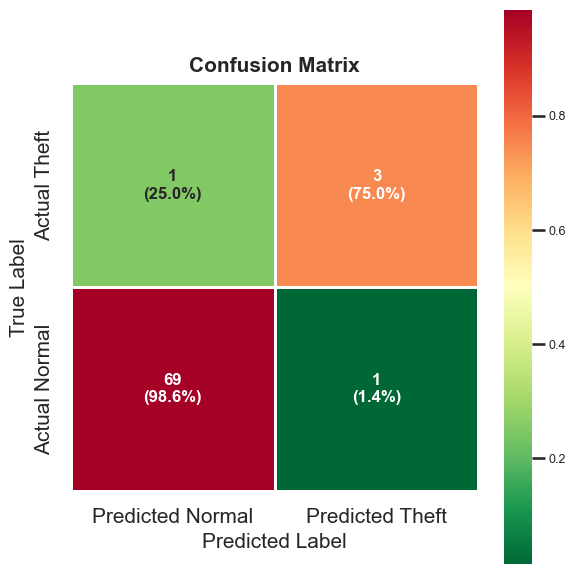

In [116]:
# best_trained_model
best_trained_model = ensemble

# Predictions
y_true = y_test
y_pred = best_trained_model.predict(X_test)

cm = confusion_matrix(y_true, y_pred)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

# Labels 
class_labels = ["Normal", "Theft"]

# Build annotation text: count + percentage
annot = np.array([
    [f"{cm[i, j]}\n({cm_norm[i, j]:.1%})" for j in range(cm.shape[1])]
    for i in range(cm.shape[0])
])

# Style
sns.set_theme(
    style="white",
    context="talk",
    font_scale=0.55   # compact, consistent with earlier plots
)

fig, ax = plt.subplots(figsize=(6, 6))
fig.patch.set_facecolor("white")

# Heatmap
sns.heatmap(
    cm_norm,
    annot=annot,
    fmt="",
    cmap="RdYlGn_r",
    cbar=True,
    linewidths=1,
    linecolor="white",
    square=True,
    xticklabels=[f"Predicted {c}" for c in class_labels],
    yticklabels=[f"Actual {c}" for c in class_labels],
    annot_kws={"size": 12, "weight": "bold"},
    ax=ax
)

# ---------- Axes ----------
ax.set_xlabel("Predicted Label", fontsize=15)
ax.set_ylabel("True Label", fontsize=15)
ax.tick_params(axis="both", labelsize=15)

# Keep standard confusion matrix orientation
ax.invert_yaxis()

# Title
ax.set_title(
    "Confusion Matrix",
    fontsize=15,
    fontweight="bold",
    pad=8
)

plt.tight_layout()
plt.show()

### Confusion Matrix Interpretation

1. **True Negatives (TN): 69**  
   - *Normal* transactions correctly identified as Normal.  
   - Very high accuracy (**98.6%**) → the model is excellent at recognizing Normal transactions.

2. **False Positives (FP): 1**  
   - Normal transactions incorrectly labeled as Theft.  
   - Very low rate (**1.4%**) → only a small number of normal transactions are wrongly flagged.

3. **False Negatives (FN): 1**  
   - Theft transactions incorrectly labeled as Normal.  
   - **25% of actual Theft cases are missed** → some thefts go undetected.

4. **True Positives (TP): 3**  
   - Theft transactions correctly identified as Theft.  
   - **75% of Theft cases correctly detected** → reasonable detection, but not perfect.

---

### Insights

- The model is **excellent at identifying Normal transactions** (high TN, low FP).  
- The model is **moderately effective at detecting Theft**, successfully catching **75%** of theft cases but **missing 25%**.  
- **Key trade-off observed**:
  - Few false positives → minimal disruption to normal transactions.
  - Some false negatives → risk of missed theft events.

#### ROC Curve

In [117]:
best_trained_model

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,"[3, 1, ...]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,42


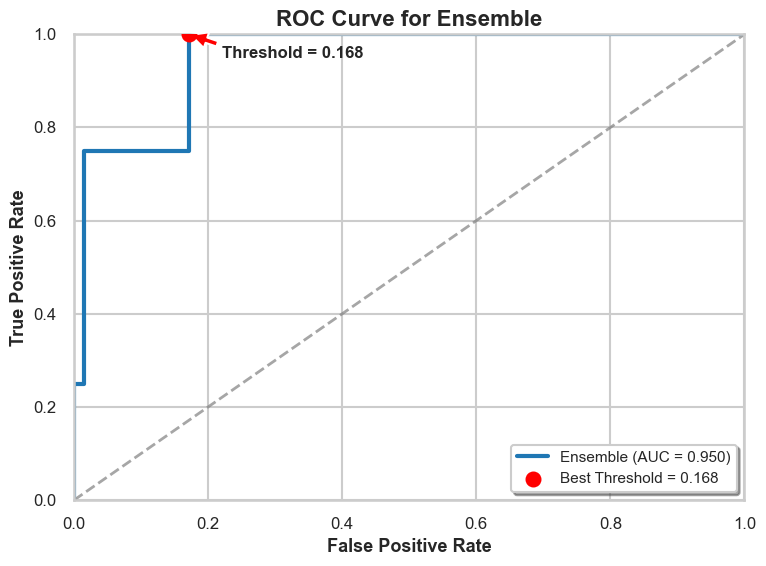

In [118]:
best_model_name = "Ensemble"

# Predict probabilities
y_pred_proba = best_trained_model.predict_proba(X_test)[:, 1]

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Find best threshold (Youden's J statistic)
youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_threshold = thresholds[best_idx]
best_fpr = fpr[best_idx]
best_tpr = tpr[best_idx]

# Style 
sns.set_theme(style="whitegrid", context="talk", font_scale=1.0)
fig, ax = plt.subplots(figsize=(8, 6))
fig.patch.set_facecolor("white")

# Plot ROC
ax.plot(fpr, tpr, lw=3, color="#1f77b4", label=f"{best_model_name} (AUC = {roc_auc:.3f})")
ax.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--", alpha=0.7)

# Highlight best threshold 
ax.scatter(best_fpr, best_tpr, color="red", s=100, zorder=5, label=f"Best Threshold = {best_threshold:.3f}")
ax.annotate(
    f"Threshold = {best_threshold:.3f}",
    xy=(best_fpr, best_tpr),
    xytext=(best_fpr + 0.05, best_tpr - 0.05),
    arrowprops=dict(facecolor='red', shrink=0.05),
    fontsize=12,
    fontweight="bold"
)

# Axes
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("False Positive Rate", fontsize=13, fontweight="bold")
ax.set_ylabel("True Positive Rate", fontsize=13, fontweight="bold")
ax.tick_params(axis="both", labelsize=12)

# Title & legend
ax.set_title(f"ROC Curve for {best_model_name}", fontsize=16, fontweight="bold")
ax.legend(loc="lower right", fontsize=11, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

### ROC Curve Interpretation

#### Understanding the Axes
- **False Positive Rate (FPR)** – Proportion of normal customers incorrectly flagged as theft. Lower values are better.
- **True Positive Rate (TPR / Recall)** – Proportion of actual theft cases correctly detected. Higher values are better.
- **Diagonal line** – Represents random guessing (AUC = 0.5). Any curve above this line indicates predictive skill.

#### Key Observations
- The **Ensemble model achieves an ROC AUC of ~0.95**, indicating **excellent ranking ability**. It is very effective at separating theft from non-theft cases across all thresholds.
- The curve rises steeply near the origin, showing that the model can achieve **high recall with relatively low false positives**.
- The highlighted **optimal threshold (~0.168)** reflects a deliberate bias toward recall, aligning with the business goal of **minimizing missed theft cases**, even at the cost of more false alarms.

### Practical Interpretation
- A high ROC AUC confirms the ensemble is strong at **prioritizing high-risk customers**.
- However, ROC AUC alone does not guarantee good performance at a chosen threshold.
- This is why **threshold-dependent metrics (F2 score, Precision@10%)** were used alongside ROC analysis.

### Conclusion
> The ROC curve demonstrates that the Ensemble model has excellent discrimination power. When combined with threshold tuning guided by the F2 score, it becomes a practical and defensible choice for electricity theft detection, balancing strong ranking performance with high recall in an imbalanced setting.


## FINANCIAL IMPACT ANALYSIS

In [119]:
# Constants
n_customers = 10_000_000                 # Average number of customers connected to electricity in Kenya
theft_rate = 0.05                        # 5% theft rate
avg_monthly_bill = 3_000                 # Average monthly KES per customer
recovery_rate = 1.0                      # 100% recoverable
annual_bill = avg_monthly_bill * 12
inspection_cost = 500                    # KES per inspection
max_inspections_per_year = 500_000
n_theft_customers = n_customers * theft_rate

# Ensemble model recall at threshold 0.168
best_model_name = "Ensemble"
recall = 0.75
best_threshold = 0.168  # previously computed ROC-optimal threshold
precision_at_10_fixed = 0.43  # as per evaluation

#### Net Financial Impact

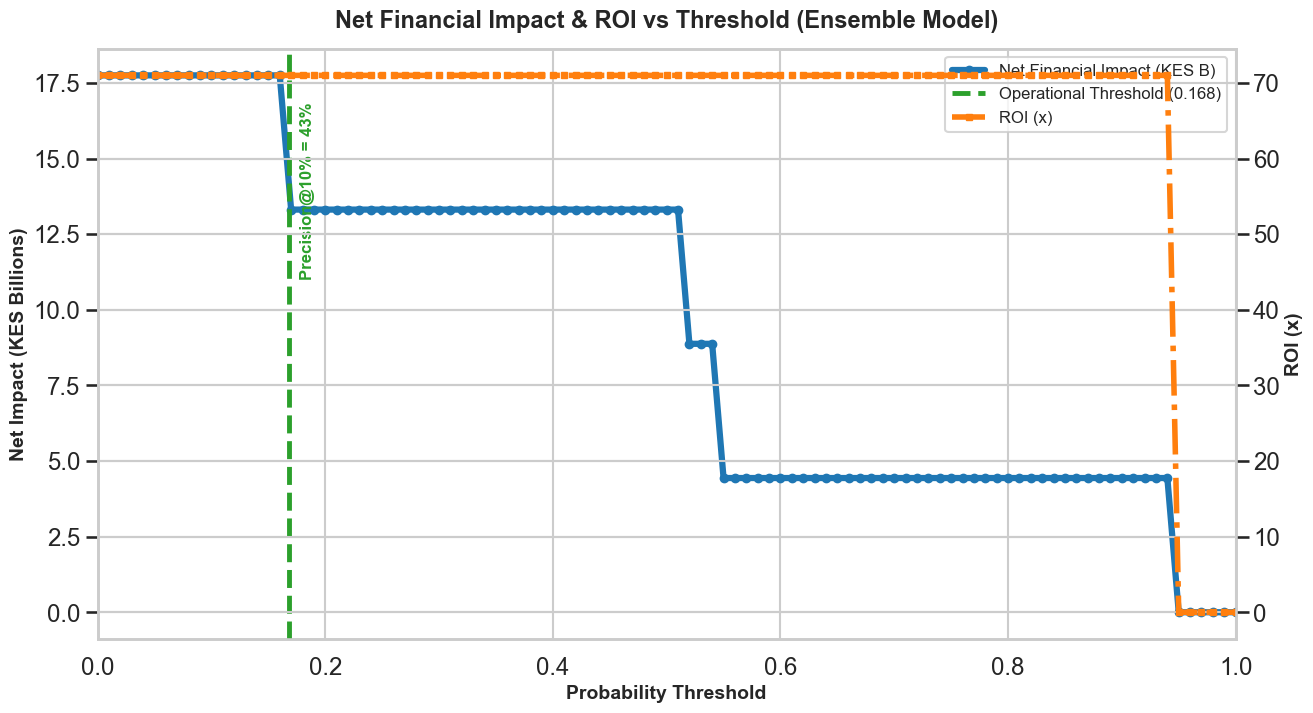


Executive Summary
    Threshold  GrossRecovery_B  InspectionCost_M  NetImpact_B   ROI  \
17       0.17             13.5             187.5        13.31  71.0   

    CustomersInspected  
17            375000.0  
Precision@10% = 43.00% at threshold = 0.168


In [120]:
# Model Predictions & Threshold Sweep
y_pred_proba = best_trained_model.predict_proba(X_test)[:, 1]

# Threshold sweep for impact analysis
thresholds = np.linspace(0, 1, 101)
f1_scores = [f1_score(y_test, (y_pred_proba >= t).astype(int)) for t in thresholds]

# Financial Impact Calculation
results = []

for t, f1 in zip(thresholds, f1_scores):
    y_pred = (y_pred_proba >= t).astype(int)

    tp = np.sum((y_test == 1) & (y_pred == 1))
    fp = np.sum((y_test == 0) & (y_pred == 1))

    recall = tp / np.sum(y_test == 1) if np.sum(y_test == 1) > 0 else 0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Scale to national population
    suspected_theft = n_theft_customers * recall
    inspected = min(suspected_theft, max_inspections_per_year)

    gross_recovery = inspected * annual_bill * recovery_rate
    inspection_costs = inspected * inspection_cost
    net_impact = gross_recovery - inspection_costs

    roi = net_impact / inspection_costs if inspection_costs > 0 else 0

    results.append({
        "Threshold": t,
        "Recall": recall,
        "Precision": precision,
        "F1Score": f1,
        "GrossRecovery_B": gross_recovery / 1e9,
        "InspectionCost_M": inspection_costs / 1e6,
        "NetImpact_B": net_impact / 1e9,
        "ROI": roi,
        "CustomersInspected": inspected
    })

impact_df = pd.DataFrame(results)

# Plotting
sns.set_theme(style="whitegrid", context="talk", font_scale=1.05)
fig, ax1 = plt.subplots(figsize=(13.5, 7.5))
fig.patch.set_facecolor("white")

# Net Financial Impact
ax1.plot(
    impact_df['Threshold'],
    impact_df['NetImpact_B'],
    color="#1f77b4",
    lw=4.5,
    marker="o",
    markersize=6,
    label="Net Financial Impact (KES B)",
    zorder=3
)

ax1.set_xlabel("Probability Threshold", fontsize=14, fontweight="bold")
ax1.set_ylabel("Net Impact (KES Billions)", fontsize=14, fontweight="bold")
ax1.set_xlim(0, 1)

# Highlight best threshold (ROC-optimal / operational)
ax1.axvline(
    best_threshold,
    color="#2ca02c",
    linestyle="--",
    lw=3.5,
    label=f"Operational Threshold ({best_threshold:.3f})",
    zorder=4
)

# Annotate Precision@10% at best threshold
ax1.text(
    best_threshold + 0.01, 
    max(impact_df['NetImpact_B'])*0.95,
    f"Precision@10% = {precision_at_10_fixed:.0%}",
    color="#2ca02c",
    fontsize=12,
    fontweight="bold",
    rotation=90,
    va="top"
)

# ROI on secondary axis
ax2 = ax1.twinx()
ax2.plot(
    impact_df['Threshold'],
    impact_df['ROI'],
    color="#ff7f0e",
    lw=4,
    linestyle="-.",
    marker="s",
    markersize=5,
    label="ROI (x)",
    zorder=2
)

ax2.set_ylabel("ROI (x)", fontsize=14, fontweight="bold")

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(
    lines1 + lines2,
    labels1 + labels2,
    loc="upper right",
    fontsize=12,
    frameon=True
)

# Title
ax1.set_title(
    f"Net Financial Impact & ROI vs Threshold ({best_model_name} Model)",
    fontsize=17,
    fontweight="bold",
    pad=15
)

plt.tight_layout()
plt.show()


# Executive Summary
best_row = impact_df.iloc[
    (impact_df['Threshold'] - best_threshold).abs().argsort()[:1]
]

print("\nExecutive Summary")
print(best_row[[
    "Threshold",
    "GrossRecovery_B",
    "InspectionCost_M",
    "NetImpact_B",
    "ROI",
    "CustomersInspected"
]].round(2))
print(f"Precision@10% = {precision_at_10_fixed:.2%} at threshold = {best_threshold:.3f}")

At the ROC-optimal threshold (~0.17), the Ensemble model captures 75% of all theft cases, inspecting only 3.75% of customers to recover KES 13.5B annually at a cost of KES 187.5M, producing a net gain of KES 13.31B and an ROI of 71×. Among the top 10% most suspicious customers, 43% are actual thefts, making inspections highly focused and efficient.

### Customers Inspected by Risk Category

In [121]:
best_model_name

'Ensemble'

In [122]:
best_trained_model

,estimators,"[('lr', ...), ('rf', ...), ...]"
,voting,'soft'
,weights,"[3, 1, ...]"
,n_jobs,-1
,flatten_transform,True
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,42


In [123]:
# Save the trained ensemble model
model_path = "models/ensemble_model.pkl"
joblib.dump(best_trained_model, model_path)

print(f"\n Ensemble model saved to {model_path}")


 Ensemble model saved to models/ensemble_model.pkl


In [124]:
# Wrap the ensemble
calibrated_model = CalibratedClassifierCV(best_trained_model, method='isotonic', cv=5)
calibrated_model.fit(X_train, y_train)

# Then predict probabilities
df['prob_theft'] = calibrated_model.predict_proba(X)[:,1]

# Create risk category
def risk_category(prob):
    if prob < 0.30:
        return 'Low Risk'
    elif prob < 0.70:
        return 'Medium Risk'
    else:
        return 'High Risk'

df['risk_category'] = df['prob_theft'].apply(risk_category)

# Save the calibrated model
with open("models/calibrated_model.pkl", "wb") as f:
    pickle.dump(calibrated_model, f)

print("Model saved to models/calibrated_model.pkl")

# Quick check
print(df[['risk_category']].value_counts())

Model saved to models/calibrated_model.pkl
risk_category
Low Risk         352
Medium Risk       10
High Risk          8
Name: count, dtype: int64


In [125]:
# Create Risk table
risk_df = (
    df[['meter_id','prob_theft', 'risk_category']]
        .rename(columns={'prob_theft': 'risk_score'})
        .copy()
)

risk_df.to_csv("data/processed/risk_scores.csv", index=False)
risk_df.head()

,meter_id,risk_score,risk_category
0,MT_001,0.644685,Medium Risk
1,MT_002,0.116142,Low Risk
2,MT_003,0.045202,Low Risk
3,MT_004,0.009091,Low Risk
4,MT_005,0.009091,Low Risk


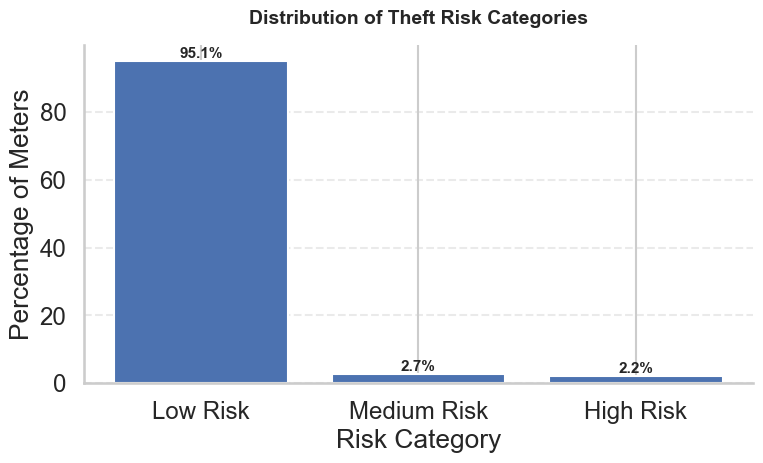

In [127]:
# Compute counts for each risk category
risk_counts = df['risk_category'].value_counts()

# Force desired order
order = ['Low Risk', 'Medium Risk', 'High Risk']

risk_pct = (
    risk_counts
    .reindex(order)
    .pipe(lambda s: (s / s.sum()) * 100)
)

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(
    risk_pct.index,
    risk_pct.values
)

# Add percentage labels
for bar, pct in zip(bars, risk_pct.values):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=11,
        fontweight='bold'
    )

# Styling
ax.set_title(
    'Distribution of Theft Risk Categories',
    fontsize=14,
    fontweight='bold',
    pad=15
)
ax.set_ylabel('Percentage of Meters')
ax.set_xlabel('Risk Category')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### Distribution of Theft Risk Categories

The bar chart shows a highly imbalanced distribution of theft risk across meters.  
The vast majority of meters (95.1%) are classified as **Low Risk**, indicating that most customers exhibit normal consumption patterns.  

Only a small fraction fall into **Medium Risk (2.7%)** and **High Risk (2.2%)** categories.  
Although these groups are small in proportion, they are operationally significant, as they represent the highest-priority candidates for targeted inspection and fraud investigation.

This visualization highlights the importance of **precision-oriented models** and **selective intervention strategies**, rather than broad, resource-intensive enforcement.


## RECOMMENDATION & CONCLUSION

### Recommendations & Strategic Actions

1. **Enrich the Dataset for Better Targeting**
   - Include additional features such as **weather patterns, region, geography, payment history, and grid instability** to improve model accuracy and optimize inspections.
   - Segment customers into **High, Medium, and Low Risk** groups to focus inspections on the most critical areas, maximizing revenue recovery efficiency.

2. **Model Deployment Strategy**
   - Deploy the **Ensemble Model at the ROC-optimal threshold (~0.17)** to maximize financial recovery while keeping inspection costs minimal.
   - Consider **Random Forest** as a complementary model for cross-checking, given its perfect recall in this dataset.
   - Logistic Regression may also serve as a benchmark for comparison in periodic evaluations.

3. **Dynamic Threshold Management**
   - Monitor and adjust the ROC-optimal threshold **annually** to account for shifting theft patterns and maintain ROI and operational efficiency.

4. **Leverage KPI Dashboard**
   - Track:
     - **Financial Recovery** (Gross & Net)
     - **Operational Costs**
     - **ROI**
     - **Residual Losses**
   - Supports real-time strategic decision-making, audit reporting, and operational oversight.

5. **Operational Recommendations**
   - Limit inspections to a **manageable proportion of customers** (~3.75% at ROC-optimal threshold) to balance cost and impact.
   - Use risk-based targeting to reduce unnecessary inspections while maximizing recovered revenue.


### Conclusion
- Electricity theft signals are **heterogeneous**: some cases are linearly separable, while others require non-linear interaction    modeling. An ensemble captures both.
- Implementing the **Ensemble model at ROC-optimal threshold** provides a **highly effective and financially efficient solution** to electricity theft.  
- The program **recovers KES 13.5B annually**, with **minimal operational cost**, leaving negligible residual losses.  
- Risk-based inspection targeting ensures **high ROI (71×)** while remaining within field team capacity.  
- Continuous monitoring through KPIs and refinement of features will **sustain long-term impact and improve grid efficiency**.
